In [2]:
# For handling data and JSON files
import json
import numpy as np
import os

# For splitting the dataset
from sklearn.model_selection import train_test_split

# For machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# For data normalization
from sklearn.preprocessing import MinMaxScaler

# For visualization
import matplotlib.pyplot as plt

# For pose detection
from ultralytics import YOLO

# For softmax
from scipy.special import softmax

# For counting classes
from collections import Counter


In [3]:
# Define the mapping of exercise names to labels
exercise_labels = {
    "Discurweper.json": 0,
    "Estafette.json": 1,
    "Hoogspringen.json": 2,
    "Hordenlopen.json": 3,
    "Kogelstoten.json": 4,
    "Speerwerpen.json": 5,
    "sprint_start.json": 6,
    "sprint.json": 7,
    "Verspringen.json": 8,
}

def load_keypoints(json_folder):
    X, y = [], []
    expected_num_keypoints = 17 * 2  # 17 keypoints with x, y coordinates

    for json_file, label in exercise_labels.items():
        json_path = os.path.join(json_folder, json_file)
        if not os.path.exists(json_path):
            print(f"Warning: {json_file} does not exist in {json_folder}. Skipping.")
            continue

        with open(json_path, "r") as f:
            data = json.load(f)

        for annotation in data["annotations"]:
            keypoints = annotation["keypoints"]
            if len(keypoints) < 51:  # 17 keypoints * 3 (x, y, visibility)
                print(f"Warning: Annotation ID {annotation['id']} in {json_file} has insufficient keypoints. Skipping.")
                continue

            # Extract x, y coordinates only and flatten
            normalized_keypoints = np.array(keypoints).reshape(-1, 3)[:, :2].flatten()

            # Pad or truncate to ensure consistent length
            if len(normalized_keypoints) < expected_num_keypoints:
                normalized_keypoints = np.pad(
                    normalized_keypoints,
                    (0, expected_num_keypoints - len(normalized_keypoints)),
                    mode="constant"
                )
            elif len(normalized_keypoints) > expected_num_keypoints:
                normalized_keypoints = normalized_keypoints[:expected_num_keypoints]

            X.append(normalized_keypoints)
            y.append(label)
    
    return np.array(X), np.array(y)

# Path to folder containing JSON files
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Verify the shapes
print(f"Feature matrix shape: {X.shape}")
print(f"Labels array shape: {y.shape}")


Feature matrix shape: (17662, 34)
Labels array shape: (17662,)


              precision    recall  f1-score   support

           0       0.88      0.93      0.91       458
           1       0.88      0.88      0.88       396
           2       0.92      0.93      0.93       345
           3       0.90      0.90      0.90       424
           4       0.97      0.98      0.97       406
           5       0.94      0.92      0.93       445
           6       0.96      0.94      0.95       504
           7       0.89      0.83      0.86       259
           8       0.89      0.90      0.89       296

    accuracy                           0.92      3533
   macro avg       0.91      0.91      0.91      3533
weighted avg       0.92      0.92      0.92      3533



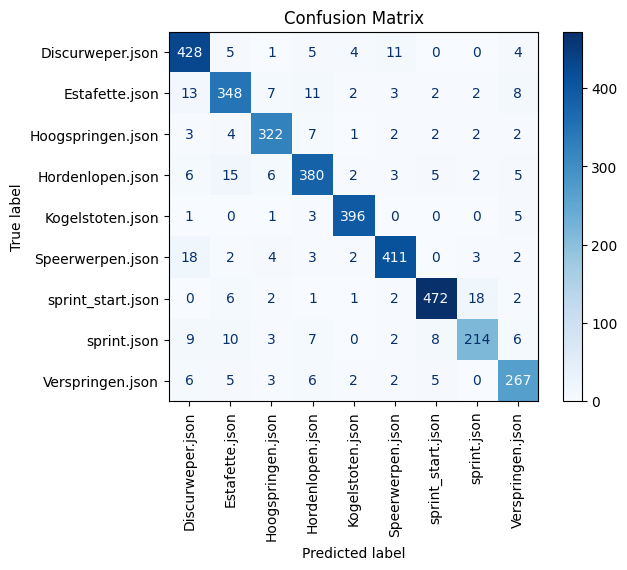

In [4]:
# Initialize the scaler
scaler = MinMaxScaler()

# Split data into training and testing sets first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest
clf = RandomForestClassifier()
clf.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(exercise_labels.keys()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


In [5]:
# Reverse mapping of exercise labels
exercise_labels_inv = {v: k for k, v in exercise_labels.items()}


In [6]:
def extract_keypoints_and_predict(frame, model, clf, scaler):
    # Run the YOLO pose model
    results = model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        return None, None  # Skip if no keypoints detected
    
    # Initialize variables to store the keypoints of the largest person
    largest_area = 0
    selected_keypoints = None

    for result in results:
        if result.keypoints is not None and result.boxes is not None and len(result.boxes) > 0:
            keypoints = result.keypoints.xy.cpu().numpy().reshape(-1, 2)  # x, y coordinates
            bbox = result.boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
            x_min, y_min, x_max, y_max = bbox
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min
            area = bbox_width * bbox_height

            if area > largest_area:
                largest_area = area
                selected_keypoints = keypoints.flatten()

    if selected_keypoints is None:
        return None, None

    # Check if the number of keypoints matches the expected number
    expected_num_features = scaler.n_features_in_
    if selected_keypoints.size != expected_num_features:
        print(f"Expected {expected_num_features} features, but got {selected_keypoints.size} features")
        return None, None

    # Normalize keypoints
    normalized_keypoints = scaler.transform([selected_keypoints])

    # Predict class and probabilities
    exercise_class = clf.predict(normalized_keypoints)
    exercise_class_proba = clf.predict_proba(normalized_keypoints)

    # Apply softmax to the confidence scores if not already probabilities
    exercise_class_proba = softmax(exercise_class_proba, axis=1)

    return exercise_class[0], exercise_class_proba[0]


In [7]:
import cv2

model = YOLO("yolov8s-pose.pt")  # Replace with your model path if different
# Path to the video
video_path = '/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Hoogspringen/segment_000001.mp4'
cap = cv2.VideoCapture(video_path)

frame_count = 0
class_counts = Counter()
class_probabilities = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    try:
        exercise_class, exercise_class_proba = extract_keypoints_and_predict(frame, model, clf, scaler)
        if exercise_class is not None:
            frame_count += 1
            class_counts[exercise_class] += 1
            class_probabilities.append(exercise_class_proba)
    except ValueError as e:
        print(f"Skipping frame due to error: {e}")
        continue  # Skip problematic frames

cap.release()

# Calculate overall percentages based on frame count
class_labels = clf.classes_
total_frames = sum(class_counts.values())

if total_frames == 0:
    print("No frames were classified.")
else:
    class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
    
    # Calculate average probabilities across all frames
    if class_probabilities:
        average_probabilities = np.mean(class_probabilities, axis=0)
        probability_percentages = {exercise_labels_inv[i]: p * 100 for i, p in enumerate(average_probabilities)}
    else:
        probability_percentages = {}

    # Output results
    print("Class Percentages (Based on Frame Count):")
    for cls, pct in class_percentages.items():
        print(f"{cls}: {pct:.2f}%")
    
    print("\nAverage Probabilities (Softmax Scores):")
    for cls, pct in probability_percentages.items():
        print(f"{cls}: {pct:.2f}%")



0: 384x640 1 person, 123.1ms
Speed: 4.2ms preprocess, 123.1ms inference, 11.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 140.1ms
Speed: 2.1ms preprocess, 140.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 75.7ms
Speed: 0.7ms preprocess, 75.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 74.3ms
Speed: 0.7ms preprocess, 74.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 88.0ms
Speed: 0.7ms preprocess, 88.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 71.4ms
Speed: 2.3ms preprocess, 71.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 79.9ms
Speed: 0.6ms preprocess, 79.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 77.4ms
Speed: 0.7ms preprocess, 77.4ms inference, 0.4ms postprocess per image at shape (1, 

In [8]:
# Output results
print("Class Percentages (Based on Frame Count):")
for cls, pct in class_percentages.items():
    print(f"{cls}: {pct:.2f}%")

print("\nAverage Probabilities (Softmax Scores):")
for cls, pct in probability_percentages.items():
    print(f"{cls}: {pct:.2f}%")



Class Percentages (Based on Frame Count):
Hoogspringen.json: 100.00%

Average Probabilities (Softmax Scores):
Discurweper.json: 9.77%
Estafette.json: 9.94%
Hoogspringen.json: 22.21%
Hordenlopen.json: 10.01%
Kogelstoten.json: 9.57%
Speerwerpen.json: 9.52%
sprint_start.json: 9.71%
sprint.json: 9.69%
Verspringen.json: 9.59%


In [9]:
import joblib
import os

# Define the directory to save the files
save_dir = "Testing"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Save the classifier
joblib.dump(clf, os.path.join(save_dir, "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/exercise_classifier.pkl"))

# Save the scaler
joblib.dump(scaler, os.path.join(save_dir, "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/scaler.pkl"))

# Save the label mappings
joblib.dump(exercise_labels_inv, os.path.join(save_dir, "exercise_labels.pkl"))

print("Model, scaler, and labels saved successfully.")

Model, scaler, and labels saved successfully.


Class distribution in dataset: {np.int64(0): np.int64(2377), np.int64(1): np.int64(1904), np.int64(2): np.int64(1740), np.int64(3): np.int64(2099), np.int64(4): np.int64(1969), np.int64(5): np.int64(2121), np.int64(6): np.int64(2665), np.int64(7): np.int64(1284), np.int64(8): np.int64(1503)}


Model and scaler saved as 'rf_model.pkl' and 'scaler.pkl'.
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       475
           1       0.87      0.87      0.87       381
           2       0.94      0.91      0.93       348
           3       0.90      0.90      0.90       420
           4       0.96      0.97      0.97       394
           5       0.92      0.95      0.94       424
           6       0.95      0.95      0.95       533
           7       0.89      0.85      0.87       257
           8       0.92      0.90      0.91       301

    accuracy                           0.92      3533
   macro avg       0.92      0.91      0.92      3533
weighted avg       0.92      0.92      0.92      3533



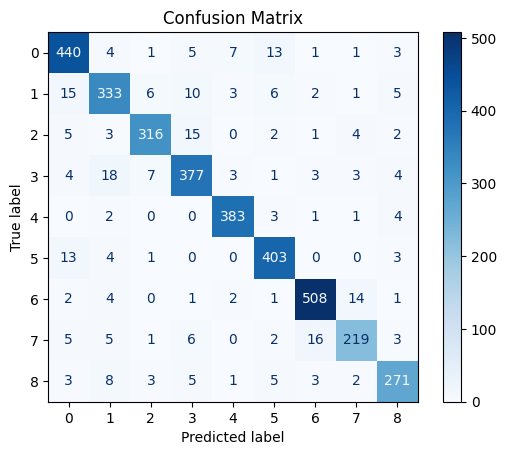

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import numpy as np
import matplotlib.pyplot as plt

# Initialize the scaler
scaler = MinMaxScaler()

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution in dataset:", dict(zip(unique, counts)))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

# Save the model and scaler for future use
joblib.dump(clf, "rf_model.pkl")
joblib.dump(scaler, "scaler_model.pkl")
print("Model and scaler saved as 'rf_model.pkl' and 'scaler.pkl'.")

# Predict on the test set
y_pred = clf.predict(X_test_scaled)

# Evaluate model performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [11]:
# Reverse mapping of exercise labels
exercise_labels_inv = {v: k for k, v in exercise_labels.items()}

In [12]:
def extract_keypoints_and_predict(frame, model, clf, scaler):
    # Run the YOLO pose model
    results = model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        return None, None  # Skip if no keypoints detected
    
    # Initialize variables to store the keypoints of the largest person
    largest_area = 0
    selected_keypoints = None

    for result in results:
        if result.keypoints is not None and result.boxes is not None and len(result.boxes) > 0:
            keypoints = result.keypoints.xy.cpu().numpy().reshape(-1, 2)  # x, y coordinates
            bbox = result.boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
            x_min, y_min, x_max, y_max = bbox
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min
            area = bbox_width * bbox_height

            if area > largest_area:
                largest_area = area
                selected_keypoints = keypoints.flatten()

    if selected_keypoints is None:
        return None, None

    # Check if the number of keypoints matches the expected number
    expected_num_features = scaler.n_features_in_
    if selected_keypoints.size != expected_num_features:
        print(f"Expected {expected_num_features} features, but got {selected_keypoints.size} features")
        return None, None

    # Normalize keypoints
    normalized_keypoints = scaler.transform([selected_keypoints])

    # Predict class and probabilities
    exercise_class = clf.predict(normalized_keypoints)
    exercise_class_proba = clf.predict_proba(normalized_keypoints)

    # Apply softmax to the confidence scores if not already probabilities
    exercise_class_proba = softmax(exercise_class_proba, axis=1)

    return exercise_class[0], exercise_class_proba[0]

In [13]:
import cv2

model = YOLO("yolov8s-pose.pt")  # Replace with your model path if different
# Path to the video
video_path = '/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Hoogspringen/segment_000001.mp4'
cap = cv2.VideoCapture(video_path)

frame_count = 0
class_counts = Counter()
class_probabilities = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    try:
        exercise_class, exercise_class_proba = extract_keypoints_and_predict(frame, model, clf, scaler)
        if exercise_class is not None:
            frame_count += 1
            class_counts[exercise_class] += 1
            class_probabilities.append(exercise_class_proba)
    except ValueError as e:
        print(f"Skipping frame due to error: {e}")
        continue  # Skip problematic frames

cap.release()

# Calculate overall percentages based on frame count
class_labels = clf.classes_
total_frames = sum(class_counts.values())

if total_frames == 0:
    print("No frames were classified.")
else:
    class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
    
    # Calculate average probabilities across all frames
    if class_probabilities:
        average_probabilities = np.mean(class_probabilities, axis=0)
        probability_percentages = {exercise_labels_inv[i]: p * 100 for i, p in enumerate(average_probabilities)}
    else:
        probability_percentages = {}

    # Output results
    print("Class Percentages (Based on Frame Count):")
    for cls, pct in class_percentages.items():
        print(f"{cls}: {pct:.2f}%")
    
    print("\nAverage Probabilities (Softmax Scores):")
    for cls, pct in probability_percentages.items():
        print(f"{cls}: {pct:.2f}%")


0: 384x640 1 person, 80.0ms
Speed: 0.8ms preprocess, 80.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 70.3ms
Speed: 0.6ms preprocess, 70.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 71.3ms
Speed: 1.2ms preprocess, 71.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 73.8ms
Speed: 0.7ms preprocess, 73.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 67.4ms
Speed: 0.6ms preprocess, 67.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 71.6ms
Speed: 0.6ms preprocess, 71.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 74.7ms
Speed: 0.6ms preprocess, 74.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 67.3ms
Speed: 0.6ms preprocess, 67.3ms inference, 0.4ms postprocess per image at shape (1, 3, 38

In [14]:
# Output results
print("Class Percentages (Based on Frame Count):")
for cls, pct in class_percentages.items():
    print(f"{cls}: {pct:.2f}%")
    
print("\nAverage Probabilities (Softmax Scores):")
for cls, pct in probability_percentages.items():
    print(f"{cls}: {pct:.2f}%")



Class Percentages (Based on Frame Count):
Hoogspringen.json: 97.00%
Discurweper.json: 0.64%
Estafette.json: 0.64%
sprint.json: 1.72%

Average Probabilities (Softmax Scores):
Discurweper.json: 9.90%
Estafette.json: 10.03%
Hoogspringen.json: 21.56%
Hordenlopen.json: 10.19%
Kogelstoten.json: 9.59%
Speerwerpen.json: 9.56%
sprint_start.json: 9.75%
sprint.json: 9.79%
Verspringen.json: 9.62%


In [15]:
# import tensorflow as tf
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# import pandas as pd
# import numpy as np

# # Assuming 'df' is already prepared
# X = df[['width', 'height', 'aspect_ratio', 'area', 'avg_distance']].values
# y = df['score'].values

# # Normalize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Build the DNN model
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# # Train the model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=100,
#     batch_size=32,
#     verbose=1
# )

# # Evaluate the model
# y_pred = model.predict(X_test).flatten()
# mse = mean_squared_error(y_test, y_pred)
# print(f"Test Mean Squared Error: {mse}")

# # Plot training history
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss')
# plt.show()


Epoch 1/100


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - loss: 4.1868 - mae: 1.6104 - val_loss: 1.3185 - val_mae: 0.8965
Epoch 2/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 1.6519 - mae: 1.0044 - val_loss: 1.2854 - val_mae: 0.8798
Epoch 3/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 1.5211 - mae: 0.9585 - val_loss: 1.2580 - val_mae: 0.8671
Epoch 4/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 1.4495 - mae: 0.9323 - val_loss: 1.2601 - val_mae: 0.8685
Epoch 5/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 1.4558 - mae: 0.9331 - val_loss: 1.2482 - val_mae: 0.8657
Epoch 6/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 1.4655 - mae: 0.9382 - val_loss: 1.2372 - val_mae: 0.8590
Epoch 7/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 1.3954 - mae: 0.9122 - val_loss: 1.2587 - val_mae: 0.8692
Epoch 8/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 1.4571 - mae: 0.9328 - val_loss: 1.2628 - val_mae: 0.8780
Epoch 9/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 

Test Mean Squared Error: 1.08715966739003


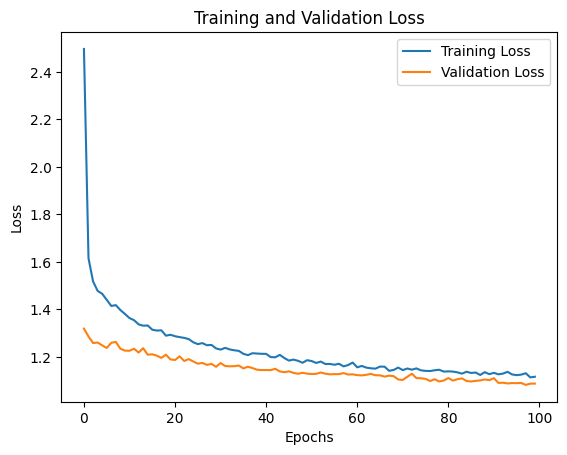

In [16]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Directory containing the JSON files
json_dir = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore"

# Function to extract features from a single JSON file
def extract_features(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Check if 'segments' key exists
    if 'segments' not in data:
        print(f"'segments' key not found in file: {json_path}")
        return pd.DataFrame()  # Return an empty DataFrame for this file

    rows = []
    for segment, details in data['segments'].items():
        score = details.get('score', 0)  # Default score to 0 if missing
        for annotation in details.get('annotations', []):  # Default to empty list if missing
            bbox = annotation.get('bbox', [0, 0, 0, 0])  # Default bbox to zeros
            area = annotation.get('area', 0)  # Default area to 0
            keypoints = np.array(annotation.get('keypoints', [])).reshape(-1, 3) if annotation.get('keypoints') else []

            # Compute features
            width, height = bbox[2], bbox[3]
            aspect_ratio = width / height if height != 0 else 0
            distances = [
                np.linalg.norm(keypoints[i][:2] - keypoints[j][:2])
                for i in range(len(keypoints))
                for j in range(i + 1, len(keypoints))
                if keypoints[i][2] > 0 and keypoints[j][2] > 0
            ]
            avg_distance = np.mean(distances) if distances else 0

            # Append row
            rows.append({
                'segment': segment,
                'score': score,
                'width': width,
                'height': height,
                'aspect_ratio': aspect_ratio,
                'area': area,
                'avg_distance': avg_distance,
            })
    return pd.DataFrame(rows)


# Aggregate all data
all_data = pd.DataFrame()
for file_name in os.listdir(json_dir):
    if file_name.endswith(".json"):
        file_path = os.path.join(json_dir, file_name)
        df = extract_features(file_path)
        all_data = pd.concat([all_data, df], ignore_index=True)

# Prepare the dataset
X = all_data[['width', 'height', 'aspect_ratio', 'area', 'avg_distance']].values
y = all_data['score'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler for later use
import joblib
joblib.dump(scaler, "scoring_scaler.pkl")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the DNN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {mse}")

# Save the trained model
model.save("scoring_model.h5")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Epoch 1/100


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - loss: 2.1351 - mae: 2.6014 - val_loss: 0.5075 - val_mae: 0.8859
Epoch 2/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.7557 - mae: 1.1648 - val_loss: 0.4912 - val_mae: 0.8701
Epoch 3/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.6315 - mae: 1.0261 - val_loss: 0.4736 - val_mae: 0.8452
Epoch 4/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.5748 - mae: 0.9591 - val_loss: 0.4726 - val_mae: 0.8421
Epoch 5/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 0.5605 - mae: 0.9434 - val_loss: 0.4760 - val_mae: 0.8460
Epoch 6/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.5471 - mae: 0.9284 - val_loss: 0.4693 - val_mae: 0.8372
Epoch 7/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.5307 - mae: 0.9073 - val_loss: 0.4691 - val_mae: 0.8417
Epoch 8/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.5254 - mae: 0.8998 - val_loss: 0.4702 - val_mae: 0.8410
Epoch 9/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 

Test Mean Squared Error (rounded): 1.179190340909091


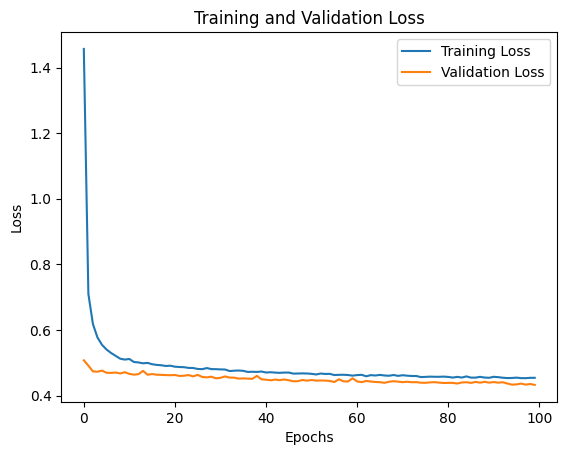

In [17]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Directory containing the JSON files
json_dir = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore"

# Function to extract features from a single JSON file
# Function to extract features from a single JSON file
def extract_features(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    rows = []
    if 'segments' in data:
        for segment, details in data['segments'].items():
            score = details['score']
            for annotation in details['annotations']:
                bbox = annotation['bbox']
                area = annotation['area']
                keypoints = np.array(annotation['keypoints']).reshape(-1, 3)

                # Compute features
                width, height = bbox[2], bbox[3]
                aspect_ratio = width / height
                distances = [
                    np.linalg.norm(keypoints[i][:2] - keypoints[j][:2])
                    for i in range(len(keypoints))
                    for j in range(i + 1, len(keypoints))
                    if keypoints[i][2] > 0 and keypoints[j][2] > 0
                ]
                avg_distance = np.mean(distances) if distances else 0

                # Append row
                rows.append({
                    'segment': segment,
                    'score': score,
                    'width': width,
                    'height': height,
                    'aspect_ratio': aspect_ratio,
                    'area': area,
                    'avg_distance': avg_distance,
                })
    else:
        print(f"Key 'segments' not found in {json_path}")
    
    return pd.DataFrame(rows)

# Aggregate all data
all_data = pd.DataFrame()
for file_name in os.listdir(json_dir):
    if file_name.endswith(".json"):
        file_path = os.path.join(json_dir, file_name)
        df = extract_features(file_path)
        all_data = pd.concat([all_data, df], ignore_index=True)

# Prepare the dataset
X = all_data[['width', 'height', 'aspect_ratio', 'area', 'avg_distance']].values
y = all_data['score'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler for later use
import joblib
joblib.dump(scaler, "scoring_scaler.pkl")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the DNN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
])

model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test).flatten()

def round_to_nearest_half(x):
    return round(x * 2) / 2


# Round predictions to the nearest 0.5
y_pred_rounded = [round_to_nearest_half(score) for score in y_pred]

# Calculate MSE for the rounded predictions
mse = mean_squared_error(y_test, y_pred_rounded)  # Corrected line
print(f"Test Mean Squared Error (rounded): {mse}")



# Save the trained model
model.save("scoring_model2.h5")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [18]:
import cv2
import numpy as np
import joblib  # Use joblib for loading the pickle model
import tensorflow as tf

# Load the classification model (Random Forest)
classification_model = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/exercise_classifier.pkl")

# Define custom objects if needed (for metrics, loss functions, etc.)
custom_objects = {
    'mse': tf.keras.metrics.MeanSquaredError()  # Make sure to specify custom metrics if needed
}

# Load the scoring model with custom objects
scoring_model = tf.keras.models.load_model(
    "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/scoring_model.h5",
    custom_objects=custom_objects
)

# Load the scaler used for feature scaling
scaler = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/scaler.pkl")

# Function to extract features from a video
def extract_features_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    keypoints_list = []
    bounding_boxes = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        def extract_keypoints_and_bbox(frame):
            # Implement keypoint extraction and bounding box logic here
            # Example:
            keypoints = model.detect_keypoints(frame)  # Replace with your actual model or logic
            bbox = model.detect_bbox(frame)  # Replace with your actual bounding box detection logic
            return keypoints, bbox

        # Process frame (example: extract keypoints using your keypoint detection logic)
        keypoints, bbox = extract_keypoints_and_bbox(frame)
        if keypoints is not None and bbox is not None:
            keypoints_list.append(keypoints)
            bounding_boxes.append(bbox)

    cap.release()

    # Aggregate features
    if not keypoints_list or not bounding_boxes:
        raise ValueError("No keypoints or bounding boxes extracted from the video.")

    # Calculate features
    width = np.mean([bbox[2] for bbox in bounding_boxes])
    height = np.mean([bbox[3] for bbox in bounding_boxes])
    aspect_ratio = width / height
    area = np.mean([bbox[2] * bbox[3] for bbox in bounding_boxes])

    distances = []
    for keypoints in keypoints_list:
        keypoints = np.array(keypoints).reshape(-1, 3)
        dist = [
            np.linalg.norm(keypoints[i][:2] - keypoints[j][:2])
            for i in range(len(keypoints))
            for j in range(i + 1, len(keypoints))
            if keypoints[i][2] > 0 and keypoints[j][2] > 0
        ]
        distances.append(np.mean(dist) if dist else 0)

    avg_distance = np.mean(distances)

    return np.array([[width, height, aspect_ratio, area, avg_distance]])

# Function to classify and score a video
def classify_and_score_video(video_path):
    # Extract features
    features = extract_features_from_video(video_path)
    features_scaled = scaler.transform(features)  # Scale features using the same scaler

    # Predict exercise type using the Random Forest model
    exercise_class = classification_model.predict(features_scaled)[0]  # Direct prediction
    print(f"Classified Exercise: {exercise_class}")

    # Predict score using the scoring model
    score = scoring_model.predict(features_scaled)[0][0]
    print(f"Predicted Score: {score}")

    return exercise_class, score

# Example usage
video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Discurweper/segment_001557.mp4"
try:
    exercise_class, predicted_score = classify_and_score_video(video_path)
    print(f"Exercise Class: {exercise_class}, Score: {predicted_score}")
except Exception as e:
    print(f"Error processing video: {e}")


Error processing video: 'Sequential' object has no attribute 'detect_keypoints'


In [19]:
import cv2
import numpy as np
import joblib  # For loading the pickle model
import tensorflow as tf
from ultralytics import YOLO  # Import YOLOv8 from ultralytics

# Load the classification model (Random Forest)
classification_model = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/exercise_classifier.pkl")

# Define custom objects if needed (for metrics, loss functions, etc.)
custom_objects = {
    'mse': tf.keras.metrics.MeanSquaredError()  # Make sure to specify custom metrics if needed
}

# Load the scoring model with custom objects
scoring_model = tf.keras.models.load_model(
    "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/scoring_model.h5",
    custom_objects=custom_objects
)

# Load the scaler used for feature scaling
scaler = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/scaler.pkl")

# Load YOLOv8 Pose model (YOLOv8s-pose)
yolo_model = YOLO('yolov8s-pose.pt')  # Load the pretrained pose model from Ultralytics

# Function to extract features from a video using YOLOv8 Pose
def extract_features_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    keypoints_list = []
    bounding_boxes = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame from BGR to RGB for YOLOv8 Pose model
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Use YOLOv8 Pose model to detect keypoints
        results = yolo_model.predict(frame_rgb)

        # Debugging: Inspect detection results
        print(f"Detection results: {results}")

        # Check if results contain boxes and keypoints
        if len(results[0].boxes) > 0:
            for result in results[0].boxes:
                print(f"Bounding Box: {result.xywh}")
            for keypoints in results[0].keypoints:
                print(f"Keypoints: {keypoints}")

            # Extract keypoints and bounding box
            for result in results[0].boxes:
                bbox = result.xywh[0][:4].numpy()  # Bounding box: [x, y, width, height]
                keypoints = result.xywh[0][5:].numpy()  # Keypoints
                keypoints_list.append(keypoints)
                bounding_boxes.append(bbox)

        else:
            print("No bounding boxes detected in this frame.")

    cap.release()

    if not keypoints_list or not bounding_boxes:
        raise ValueError("No keypoints or bounding boxes extracted from the video.")

    # Calculate features: width, height, aspect ratio, etc.
    width = np.mean([bbox[2] for bbox in bounding_boxes])
    height = np.mean([bbox[3] for bbox in bounding_boxes])
    aspect_ratio = width / height
    area = np.mean([bbox[2] * bbox[3] for bbox in bounding_boxes])

    avg_distance = np.mean([
        np.linalg.norm(keypoints[i][:2] - keypoints[j][:2])
        for keypoints in keypoints_list
        for i in range(len(keypoints))
        for j in range(i + 1, len(keypoints))
        if keypoints[i][2] > 0 and keypoints[j][2] > 0
    ])

    # Additional features if needed (for example, keypoint distances, pose angles, etc.)
    # For now, using the existing 5 features (width, height, aspect_ratio, area, avg_distance)
    return np.array([[width, height, aspect_ratio, area, avg_distance]])

# Function to classify and score a video
def classify_and_score_video(video_path):
    # Extract features
    try:
        features = extract_features_from_video(video_path)
        print(f"Extracted features: {features}")  # Debugging line
    except ValueError as e:
        print(f"Error extracting features: {e}")
        return None, None  # Return None if no features are extracted

    # Check if features have the expected shape (5 features)
    print(f"Features shape before scaling: {features.shape}")  # Debugging line
    features_scaled = scaler.transform(features)  # Scale features using the same scaler

    # Check if features are correctly scaled
    print(f"Scaled features: {features_scaled}")  # Debugging line

    # Predict exercise type using the Random Forest model
    exercise_class = classification_model.predict(features_scaled)[0]  # Direct prediction
    print(f"Classified Exercise: {exercise_class}")

    # Predict score using the scoring model
    score = scoring_model.predict(features_scaled)[0][0]
    print(f"Predicted Score: {score}")

    return exercise_class, score

# Example usage
video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Discurweper/segment_001557.mp4"
try:
    exercise_class, predicted_score = classify_and_score_video(video_path)
    if exercise_class is not None and predicted_score is not None:
        print(f"Exercise Class: {exercise_class}, Score: {predicted_score}")
    else:
        print("No valid results from video processing.")
except Exception as e:
    print(f"Error processing video: {e}")



0: 640x640 1 person, 170.8ms
Speed: 5.1ms preprocess, 170.8ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 640)
Detection results: [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: ultralytics.engine.results.Keypoints object
masks: None
names: {0: 'person'}
obb: None
orig_img: array([[[157, 173, 200],
        [157, 173, 200],
        [157, 173, 200],
        ...,
        [147, 164, 190],
        [147, 164, 190],
        [147, 164, 190]],

       [[157, 173, 200],
        [157, 173, 200],
        [157, 173, 200],
        ...,
        [147, 164, 190],
        [147, 164, 190],
        [147, 164, 190]],

       [[155, 172, 198],
        [155, 172, 198],
        [155, 172, 198],
        ...,
        [147, 164, 190],
        [147, 164, 190],
        [147, 164, 190]],

       ...,

       [[159, 146, 127],
        [159, 146, 127],
        [159, 146, 127],
        ...,
        [167, 152, 137],
        [169, 15

/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [20]:
import cv2
import numpy as np
from collections import Counter
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import joblib
from scipy.special import softmax
from ultralytics import YOLO
from keras.metrics import MeanSquaredError

# Define the custom metric if necessary
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Register the custom function if needed
tf.keras.utils.get_custom_objects()["mse"] = mse

# Load the scoring model with the custom metric
scoring_model = tf.keras.models.load_model(
    "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/scoring_model.h5",
    custom_objects={"mse": mse}
)

# Load models and scalers
clf = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/exercise_classifier.pkl")
scaler_classification = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/scaler.pkl")
exercise_labels_inv = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/exercise_labels.pkl")
scoring_model = tf.keras.models.load_model("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/scoring_model.h5")
scaler_scoring = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/scoring_scaler.pkl")

# Load YOLO model
model = YOLO("yolov8s-pose.pt")

# Path to the video
video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Discurweper/segment_001557.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = 0
class_counts = Counter()
class_probabilities = []
frame_scores = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Step 1: Extract Keypoints
    results = model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        continue

    keypoints = results[0].keypoints.xy.cpu().numpy().flatten()  # x, y coordinates

    # Step 2: Classify Exercise
    if keypoints.size == scaler_classification.n_features_in_:
        normalized_keypoints = scaler_classification.transform([keypoints])
        exercise_class = clf.predict(normalized_keypoints)[0]
        exercise_class_proba = clf.predict_proba(normalized_keypoints)
        exercise_class_proba = softmax(exercise_class_proba, axis=1)
        class_counts[exercise_class] += 1
        class_probabilities.append(exercise_class_proba[0])

        # Step 3: Extract Scoring Features
        bbox = results[0].boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
        keypoints_reshaped = keypoints.reshape(-1, 2)

        width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
        aspect_ratio = width / height
        distances = [
            np.linalg.norm(keypoints_reshaped[i] - keypoints_reshaped[j])
            for i in range(len(keypoints_reshaped))
            for j in range(i + 1, len(keypoints_reshaped))
        ]
        avg_distance = np.mean(distances) if distances else 0
        area = width * height

        features = np.array([width, height, aspect_ratio, area, avg_distance]).reshape(1, -1)
        features_scaled = scaler_scoring.transform(features)

        # Function to round score to the closest 0.5
        def round_to_closest_half(score):
            return round(score * 2) / 2

        # Step 4: Predict Score
        score = scoring_model.predict(features_scaled).flatten()[0]
        rounded_score = round_to_closest_half(score)
        frame_scores.append(rounded_score)

        # Step 5: Annotate Frame
        label = f"{exercise_labels_inv[exercise_class]} (Score: {rounded_score:.2f})"
        cv2.putText(frame, label, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    frame_count += 1
    cv2.imshow('Video', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Step 6: Aggregate Results
total_frames = sum(class_counts.values())
if total_frames > 0:
    class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
    average_probabilities = np.mean(class_probabilities, axis=0)
    average_scores = np.mean(frame_scores)

    print("Class Percentages (Based on Frame Count):")
    for cls, pct in class_percentages.items():
        print(f"{cls}: {pct:.2f}%")
    
    print("\nAverage Probabilities (Softmax Scores):")
    for cls, pct in enumerate(average_probabilities):
        print(f"{exercise_labels_inv[cls]}: {pct:.2f}%")

    print(f"\nAverage Score for the Video: {average_scores:.2f}")



0: 640x640 1 person, 138.1ms
Speed: 1.3ms preprocess, 138.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

0: 640x640 1 person, 203.5ms
Speed: 2.1ms preprocess, 203.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

0: 640x640 1 person, 141.1ms
Speed: 1.6ms preprocess, 141.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

0: 640x640 1 person, 196.8ms
Speed: 1.6ms preprocess, 196.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

0: 640x640 1 person, 123.2ms
Speed: 1.5ms preprocess, 123.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



2025-01-22 08:31:25.096 python[1164:9505] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-22 08:31:25.096 python[1164:9505] +[IMKInputSession subclass]: chose IMKInputSession_Modern


0: 640x640 1 person, 123.8ms
Speed: 1.3ms preprocess, 123.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

0: 640x640 1 person, 125.5ms
Speed: 1.3ms preprocess, 125.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

0: 640x640 1 person, 121.6ms
Speed: 1.3ms preprocess, 121.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

0: 640x640 1 person, 129.3ms
Speed: 1.3ms preprocess, 129.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

0: 640x640 1 person, 126.4ms
Speed: 1.6ms preprocess, 126.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

0: 640x640 1 person, 116.7ms
Speed: 1.2ms preprocess, 116.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

0: 6

In [21]:
# Step 6: Aggregate Results
total_frames = sum(class_counts.values())
if total_frames > 0:
    class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
    average_probabilities = np.mean(class_probabilities, axis=0)
    average_scores = np.mean(frame_scores)

    print("Class Percentages (Based on Frame Count):")
    for cls, pct in class_percentages.items():
        print(f"{cls}: {pct:.2f}%")
    
    print("\nAverage Probabilities (Softmax Scores):")
    for cls, pct in enumerate(average_probabilities):
        print(f"{exercise_labels_inv[cls]}: {pct:.2f}%")

    print(f"\nAverage Score for the Video: {average_scores:.2f}")

Class Percentages (Based on Frame Count):
Discurweper.json: 90.05%
Estafette.json: 6.28%
Speerwerpen.json: 3.66%

Average Probabilities (Softmax Scores):
Discurweper.json: 0.19%
Estafette.json: 0.11%
Hoogspringen.json: 0.10%
Hordenlopen.json: 0.10%
Kogelstoten.json: 0.10%
Speerwerpen.json: 0.10%
sprint_start.json: 0.10%
sprint.json: 0.10%
Verspringen.json: 0.10%

Average Score for the Video: 3.51


In [22]:
# import cv2
# import numpy as np
# from collections import Counter
# import tensorflow as tf
# from sklearn.preprocessing import StandardScaler
# import joblib
# from scipy.special import softmax
# from ultralytics import YOLO
# from keras.metrics import MeanSquaredError

# # Define the custom metric if necessary
# def mse(y_true, y_pred):
#     return tf.reduce_mean(tf.square(y_true - y_pred))

# # Register the custom function if needed
# tf.keras.utils.get_custom_objects()["mse"] = mse

# # Load the scoring model with the custom metric
# scoring_model = tf.keras.models.load_model(
#     "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/scoring_model2.h5",
#     custom_objects={"mse": mse}
# )

# # Load models and scalers
# clf = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/exercise_classifier.pkl")
# scaler_classification = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/scaler.pkl")
# exercise_labels_inv = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/exercise_labels.pkl")
# scoring_model = tf.keras.models.load_model("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/scoring_model.h5")
# scaler_scoring = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/scoring_scaler.pkl")

# # Load YOLO model
# model = YOLO("yolov8n-pose.pt")

# # Path to the video
# video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/DownloadVideoTest/VID20250113141952.mp4"
# cap = cv2.VideoCapture(video_path)

# frame_count = 0
# class_counts = Counter()
# class_probabilities = []
# frame_scores = []

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Step 1: Extract Keypoints
#     results = model(frame)
#     if len(results) == 0 or results[0].keypoints is None:
#         continue

#     keypoints = results[0].keypoints.xy.cpu().numpy().flatten()  # x, y coordinates

#     # Step 2: Classify Exercise
#     if keypoints.size == scaler_classification.n_features_in_:
#         normalized_keypoints = scaler_classification.transform([keypoints])
#         exercise_class = clf.predict(normalized_keypoints)[0]
#         exercise_class_proba = clf.predict_proba(normalized_keypoints)
#         exercise_class_proba = softmax(exercise_class_proba, axis=1)
#         class_counts[exercise_class] += 1
#         class_probabilities.append(exercise_class_proba[0])

#         # Step 3: Extract Scoring Features
#         bbox = results[0].boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
#         keypoints_reshaped = keypoints.reshape(-1, 2)

#         width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
#         aspect_ratio = width / height
#         distances = [
#             np.linalg.norm(keypoints_reshaped[i] - keypoints_reshaped[j])
#             for i in range(len(keypoints_reshaped))
#             for j in range(i + 1, len(keypoints_reshaped))
#         ]
#         avg_distance = np.mean(distances) if distances else 0
#         area = width * height

#         features = np.array([width, height, aspect_ratio, area, avg_distance]).reshape(1, -1)
#         features_scaled = scaler_scoring.transform(features)

#         # Function to round score to the closest 0.5
#         def round_to_closest_half(score):
#             return round(score * 2) / 2

#         # Step 4: Predict Score
#         score = scoring_model.predict(features_scaled).flatten()[0]
#         rounded_score = round_to_closest_half(score)
#         frame_scores.append(rounded_score)

#         # Step 5: Annotate Frame
#         label = f"{exercise_labels_inv[exercise_class]} (Score: {rounded_score:.2f})"
#         cv2.putText(frame, label, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
#     frame_count += 1
#     cv2.imshow('Video', frame)

#     # Press 'q' to exit
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

# # Step 6: Aggregate Results
# total_frames = sum(class_counts.values())
# if total_frames > 0:
#     class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
#     average_probabilities = np.mean(class_probabilities, axis=0)
#     average_scores = np.mean(frame_scores)

#     print("Class Percentages (Based on Frame Count):")
#     for cls, pct in class_percentages.items():
#         print(f"{cls}: {pct:.2f}%")
    
#     print("\nAverage Probabilities (Softmax Scores):")
#     for cls, pct in enumerate(average_probabilities):
#         print(f"{exercise_labels_inv[cls]}: {pct:.2f}%")

#     print(f"\nAverage Score for the Video: {average_scores:.2f}")


In [23]:
# # Step 6: Aggregate Results
# total_frames = sum(class_counts.values())
# if total_frames > 0:
#     class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
#     average_probabilities = np.mean(class_probabilities, axis=0)
#     average_scores = np.mean(frame_scores)

#     print("Class Percentages (Based on Frame Count):")
#     for cls, pct in class_percentages.items():
#         print(f"{cls}: {pct:.2f}%")
    
#     print("\nAverage Probabilities (Softmax Scores):")
#     for cls, pct in enumerate(average_probabilities):
#         print(f"{exercise_labels_inv[cls]}: {pct:.2f}%")

#     print(f"\nAverage Score for the Video: {average_scores:.2f}")

In [24]:
# import cv2
# import numpy as np
# from collections import Counter
# import tensorflow as tf
# from sklearn.preprocessing import StandardScaler
# import joblib
# from scipy.special import softmax
# from ultralytics import YOLO
# from keras.metrics import MeanSquaredError

# # Define the custom metric if necessary
# def mse(y_true, y_pred):
#     return tf.reduce_mean(tf.square(y_true - y_pred))

# # Register the custom function if needed
# tf.keras.utils.get_custom_objects()["mse"] = mse

# # Load the scoring model with the custom metric
# scoring_model = tf.keras.models.load_model(
#     "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/scoring_model2.h5",
#     custom_objects={"mse": mse}
# )

# # Load models and scalers
# clf = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/exercise_classifier.pkl")
# scaler_classification = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/scaler.pkl")
# exercise_labels_inv = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/exercise_labels.pkl")
# scoring_model = tf.keras.models.load_model("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/scoring_model.h5")
# scaler_scoring = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/scoring_scaler.pkl")

# # Load YOLO model
# model = YOLO("yolov8n-pose.pt")

# # Path to the video
# video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/DownloadVideoTest/VID20250113142324.mp4"
# cap = cv2.VideoCapture(video_path)

# frame_count = 0
# class_counts = Counter()
# class_probabilities = []
# frame_scores = []

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Step 1: Extract Keypoints
#     results = model(frame)
#     if len(results) == 0 or results[0].keypoints is None:
#         continue

#     keypoints = results[0].keypoints.xy.cpu().numpy().flatten()  # x, y coordinates

#     # Step 2: Classify Exercise
#     if keypoints.size == scaler_classification.n_features_in_:
#         normalized_keypoints = scaler_classification.transform([keypoints])
#         exercise_class = clf.predict(normalized_keypoints)[0]
#         exercise_class_proba = clf.predict_proba(normalized_keypoints)
#         exercise_class_proba = softmax(exercise_class_proba, axis=1)
#         class_counts[exercise_class] += 1
#         class_probabilities.append(exercise_class_proba[0])

#         # Step 3: Extract Scoring Features
#         bbox = results[0].boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
#         keypoints_reshaped = keypoints.reshape(-1, 2)

#         width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
#         aspect_ratio = width / height
#         distances = [
#             np.linalg.norm(keypoints_reshaped[i] - keypoints_reshaped[j])
#             for i in range(len(keypoints_reshaped))
#             for j in range(i + 1, len(keypoints_reshaped))
#         ]
#         avg_distance = np.mean(distances) if distances else 0
#         area = width * height

#         features = np.array([width, height, aspect_ratio, area, avg_distance]).reshape(1, -1)
#         features_scaled = scaler_scoring.transform(features)

#         # Function to round score to the closest 0.5
#         def round_to_closest_half(score):
#             return round(score * 2) / 2

#         # Step 4: Predict Score
#         score = scoring_model.predict(features_scaled).flatten()[0]
#         rounded_score = round_to_closest_half(score)
#         frame_scores.append(rounded_score)

#         # Step 5: Annotate Frame
#         label = f"{exercise_labels_inv[exercise_class]} (Score: {rounded_score:.2f})"
#         cv2.putText(frame, label, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
#     frame_count += 1
#     cv2.imshow('Video', frame)

#     # Press 'q' to exit
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

# # Step 6: Aggregate Results
# total_frames = sum(class_counts.values())
# if total_frames > 0:
#     class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
#     average_probabilities = np.mean(class_probabilities, axis=0)
#     average_scores = np.mean(frame_scores)

#     print("Class Percentages (Based on Frame Count):")
#     for cls, pct in class_percentages.items():
#         print(f"{cls}: {pct:.2f}%")
    
#     print("\nAverage Probabilities (Softmax Scores):")
#     for cls, pct in enumerate(average_probabilities):
#         print(f"{exercise_labels_inv[cls]}: {pct:.2f}%")

#     print(f"\nAverage Score for the Video: {average_scores:.2f}")


In [25]:
# # Step 6: Aggregate Results
# total_frames = sum(class_counts.values())
# if total_frames > 0:
#     class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
#     average_probabilities = np.mean(class_probabilities, axis=0)
#     average_scores = np.mean(frame_scores)

#     print("Class Percentages (Based on Frame Count):")
#     for cls, pct in class_percentages.items():
#         print(f"{cls}: {pct:.2f}%")
    
#     print("\nAverage Probabilities (Softmax Scores):")
#     for cls, pct in enumerate(average_probabilities):
#         print(f"{exercise_labels_inv[cls]}: {pct:.2f}%")

#     print(f"\nAverage Score for the Video: {average_scores:.2f}")

Epoch 1/100


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - loss: 2.1763 - mae: 2.6434 - val_loss: 0.5267 - val_mae: 0.9040
Epoch 2/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.8234 - mae: 1.2357 - val_loss: 0.4884 - val_mae: 0.8679
Epoch 3/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.6676 - mae: 1.0636 - val_loss: 0.4808 - val_mae: 0.8556
Epoch 4/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.6113 - mae: 0.9990 - val_loss: 0.4842 - val_mae: 0.8658
Epoch 5/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 0.5771 - mae: 0.9637 - val_loss: 0.4758 - val_mae: 0.8570
Epoch 6/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 0.5522 - mae: 0.9331 - val_loss: 0.4754 - val_mae: 0.8571
Epoch 7/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 0.5517 - mae: 0.9333 - val_loss: 0.4758 - val_mae: 0.8517
Epoch 8/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 0.5376 - mae: 0.9180 - val_loss: 0.4762 - val_mae: 0.8577
Epoch 9/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 

Test Mean Squared Error (rounded): 1.266122159090909


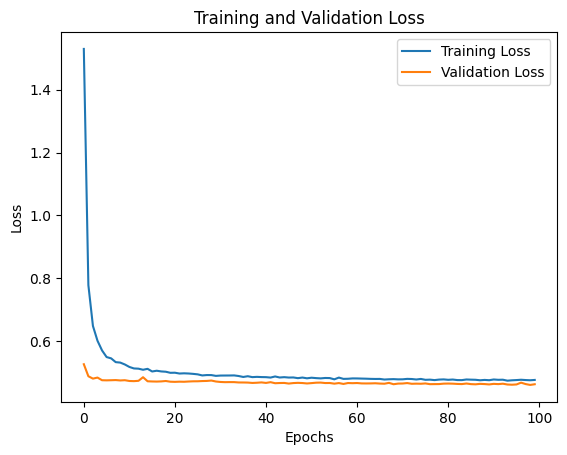

In [26]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Directory containing the JSON files
json_dir = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore"

# Function to extract features from a single JSON file
def extract_features(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    rows = []
    for segment, details in data['segments'].items():
        score = details['score']
        for annotation in details['annotations']:
            bbox = annotation['bbox']
            area = annotation['area']
            keypoints = np.array(annotation['keypoints']).reshape(-1, 3)

            # Compute features
            width, height = bbox[2], bbox[3]
            aspect_ratio = width / height
            distances = [
                np.linalg.norm(keypoints[i][:2] - keypoints[j][:2])
                for i in range(len(keypoints))
                for j in range(i + 1, len(keypoints))
                if keypoints[i][2] > 0 and keypoints[j][2] > 0
            ]
            avg_distance = np.mean(distances) if distances else 0

            # Append row
            rows.append({
                'segment': segment,
                'score': score,
                'width': width,
                'height': height,
                'aspect_ratio': aspect_ratio,
                'area': area,
                'avg_distance': avg_distance,
            })
    return pd.DataFrame(rows)

# Aggregate all data
all_data = pd.DataFrame()
for file_name in os.listdir(json_dir):
    if file_name.endswith(".json"):
        file_path = os.path.join(json_dir, file_name)
        df = extract_features(file_path)
        all_data = pd.concat([all_data, df], ignore_index=True)

# Prepare the dataset
X = all_data[['width', 'height', 'aspect_ratio', 'area', 'avg_distance']].values
y = all_data['score'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler for later use
import joblib
joblib.dump(scaler, "scoring_scaler.pkl")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the DNN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='linear')
])


model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae'])
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test).flatten()

def round_to_nearest_half(x):
    return round(x * 2) / 2


# Round predictions to the nearest 0.5
y_pred_rounded = [round_to_nearest_half(score) for score in y_pred]

# Calculate MSE for the rounded predictions
mse = mean_squared_error(y_test, y_pred_rounded)  # Corrected line
print(f"Test Mean Squared Error (rounded): {mse}")



#save the trained model
model.save("scoring_model3.h5")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [27]:
# import cv2
# import numpy as np
# from collections import Counter
# import tensorflow as tf
# from sklearn.preprocessing import StandardScaler
# import joblib
# from scipy.special import softmax
# from ultralytics import YOLO
# import json

# # Define the custom metric if necessary
# def mse(y_true, y_pred):
#     return tf.reduce_mean(tf.square(y_true - y_pred))

# # Register the custom function if needed
# tf.keras.utils.get_custom_objects()["mse"] = mse


# # Load classification model and scalers
# # Load the scoring model with the custom metric
# scoring_model = tf.keras.models.load_model(
#     "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/scoring_model3.h5",
#     custom_objects={"mse": mse}
# )

# # Load models and scalers
# clf = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/exercise_classifier.pkl")
# scaler_classification = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/scaler.pkl")
# exercise_labels_inv = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/exercise_labels.pkl")
# scoring_model = tf.keras.models.load_model("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/scoring_model.h5")
# scaler_scoring = joblib.load("/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/scoring_scaler.pkl")

# # Load YOLO model
# model = YOLO("yolov8n-pose.pt")

# # Path to the video
# video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/DownloadVideoTest/Athletics.mp4"
# cap = cv2.VideoCapture(video_path)

# frame_count = 0
# class_counts = Counter()
# class_probabilities = []
# frame_scores = []
# output_data = []  # For saving frame-level results

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     try:
#         # Step 1: Extract Keypoints
#         results = model(frame)
#         if len(results) == 0 or results[0].keypoints is None:
#             continue

#         keypoints_reshaped = results[0].keypoints.xy.cpu().numpy().reshape(-1, 3)
#         valid_keypoints = keypoints_reshaped[keypoints_reshaped[:, 2] > 0]  # Confidence > 0

#         if len(valid_keypoints) == 0:
#             continue  # Skip frames with no valid keypoints

#         # Step 2: Classify Exercise
#         flattened_keypoints = valid_keypoints[:, :2].flatten()  # Only x, y coordinates
#         if flattened_keypoints.size == scaler_classification.n_features_in_:
#             normalized_keypoints = scaler_classification.transform([flattened_keypoints])
#             exercise_class = clf.predict(normalized_keypoints)[0]
#             exercise_class_proba = clf.predict_proba(normalized_keypoints)
#             exercise_class_proba = softmax(exercise_class_proba, axis=1)
#             class_counts[exercise_class] += 1
#             class_probabilities.append(exercise_class_proba[0])

#             # Step 3: Extract Scoring Features
#             bbox = results[0].boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
#             width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
#             aspect_ratio = width / height
#             area = width * height
#             distances = [
#                 np.linalg.norm(valid_keypoints[i, :2] - valid_keypoints[j, :2])
#                 for i in range(len(valid_keypoints))
#                 for j in range(i + 1, len(valid_keypoints))
#             ]
#             avg_distance = np.mean(distances) if distances else 0

#             features = np.array([width, height, aspect_ratio, area, avg_distance]).reshape(1, -1)
#             features_scaled = scaler_scoring.transform(features)

#             # Function to round score to the closest 0.5
#             def round_to_closest_half(score):
#                 return round(score * 2) / 2

#             # Step 4: Predict Score
#             score = scoring_model.predict(features_scaled).flatten()[0]
#             rounded_score = round_to_closest_half(score)
#             frame_scores.append(rounded_score)

#             # Save frame-level data
#             output_data.append({
#                 "frame": frame_count,
#                 "exercise_class": exercise_labels_inv[exercise_class],
#                 "probabilities": exercise_class_proba[0].tolist(),
#                 "score": rounded_score
#             })

#             # Step 5: Annotate Frame
#             label = f"{exercise_labels_inv[exercise_class]} (Score: {rounded_score:.2f})"
#             cv2.putText(frame, label, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

#         frame_count += 1
#         cv2.imshow('Video', frame)

#         # Press 'q' to exit
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

#     except Exception as e:
#         print(f"Error processing frame {frame_count}: {e}")
#         continue

# cap.release()
# cv2.destroyAllWindows()

# # Step 6: Aggregate Results
# total_frames = sum(class_counts.values())
# if total_frames > 0:
#     class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
#     average_probabilities = np.mean(class_probabilities, axis=0) if class_probabilities else []
#     average_score = np.mean(frame_scores) if frame_scores else 0

#     print("Class Percentages (Based on Frame Count):")
#     for cls, pct in class_percentages.items():
#         print(f"{cls}: {pct:.2f}%")
    
#     print("\nAverage Probabilities (Softmax Scores):")
#     for cls, pct in enumerate(average_probabilities):
#         print(f"{exercise_labels_inv[cls]}: {pct:.2f}%")

#     print(f"\nAverage Score for the Video: {average_score:.2f}")

# # Save results to a JSON file
# with open("frame_results.json", "w") as f:
#     json.dump(output_data, f, indent=4)


In [28]:
# # Step 6: Aggregate Results
# total_frames = sum(class_counts.values())
# if total_frames > 0:
#     class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
#     average_probabilities = np.mean(class_probabilities, axis=0)
#     average_scores = np.mean(frame_scores)

#     print("Class Percentages (Based on Frame Count):")
#     for cls, pct in class_percentages.items():
#         print(f"{cls}: {pct:.2f}%")
    
#     print("\nAverage Probabilities (Softmax Scores):")
#     for cls, pct in enumerate(average_probabilities):
#         print(f"{exercise_labels_inv[cls]}: {pct:.2f}%")

#     print(f"\nAverage Score for the Video: {average_scores:.2f}")

Epoch 1/50


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.2360 - loss: 2.0303 - val_accuracy: 0.3527 - val_loss: 1.7608
Epoch 2/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.3813 - loss: 1.7151 - val_accuracy: 0.4104 - val_loss: 1.6439
Epoch 3/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.4172 - loss: 1.6083 - val_accuracy: 0.4478 - val_loss: 1.5565
Epoch 4/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.4503 - loss: 1.5143 - val_accuracy: 0.4750 - val_loss: 1.4710
Epoch 5/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.4865 - loss: 1.4209 - val_accuracy: 0.4956 - val_loss: 1.4111
Epoch 6/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.5047 - loss: 1.3916 - val_accuracy: 0.5058 - val_loss: 1.3923
Epoch 7/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.5314 - loss: 1.3254 - val_accuracy: 0.5214 - val_loss: 1.3459
Epoch 8/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.5415 - loss: 1.2861 - val_accurac

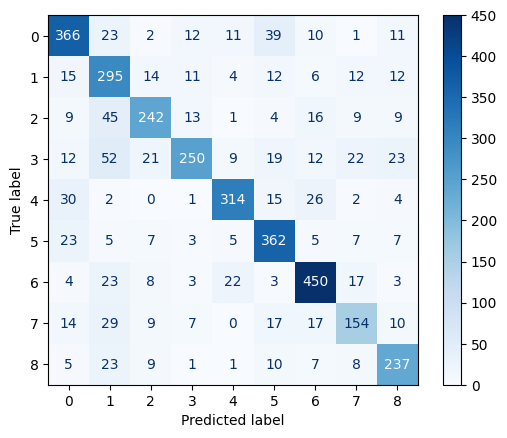

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import keras
from keras.models import Sequential
from keras.layers import Dense
import joblib

# Assuming the 'load_keypoints' function and 'exercise_labels' are already defined as per previous steps

# Load data
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the labels
# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)  # Updated argument
y_encoded = encoder.fit_transform(y.reshape(-1, 1))


# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Build a neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_encoded.shape[1], activation='softmax'))  # Output layer with softmax for multi-class classification

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model performance
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_actual = np.argmax(y_test, axis=1)

# Classification Report
target_names = [str(label) for label in encoder.categories_[0]]
print("Classification Report:")
print(classification_report(y_test_actual, y_pred_classes, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test_actual, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')


In [30]:
import joblib
import os

# Define the directory to save the files
save_dir = "Testing"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Save the classifier
joblib.dump(clf, os.path.join(save_dir, "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/exercise_classifier_again.pkl"))

# Save the scaler
joblib.dump(scaler, os.path.join(save_dir, "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/scaler_again.pkl"))

# Save the label mappings
joblib.dump(exercise_labels_inv, os.path.join(save_dir, "exercise_labels_again.pkl"))

print("Model, scaler, and labels saved successfully.")

Model, scaler, and labels saved successfully.


Epoch 1/50


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.9026 - loss: 0.7883 - val_accuracy: 0.9836 - val_loss: 0.0600
Epoch 2/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.9800 - loss: 0.0760 - val_accuracy: 0.9853 - val_loss: 0.0579
Epoch 3/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.9820 - loss: 0.0682 - val_accuracy: 0.9867 - val_loss: 0.0562
Epoch 4/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.9814 - loss: 0.0679 - val_accuracy: 0.9856 - val_loss: 0.0563
Epoch 5/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.9822 - loss: 0.0631 - val_accuracy: 0.9858 - val_loss: 0.0585
Epoch 6/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.9819 - loss: 0.0659 - val_accuracy: 0.9861 - val_loss: 0.0557
Epoch 7/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.9781 - loss: 0.0757 - val_accuracy: 0.9839 - val_loss: 0.0583
Epoch 8/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.9810 - loss: 0.0696 - val_accurac

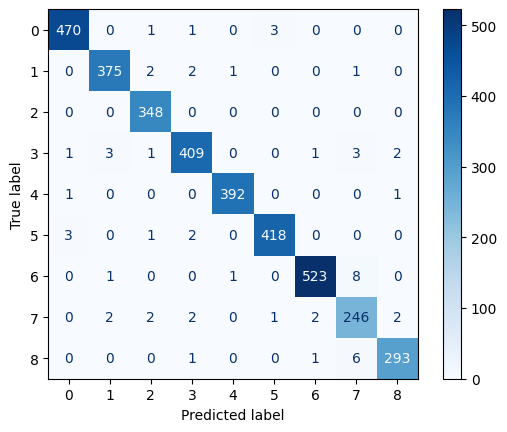

In [31]:
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense



    
# Load the previously saved Random Forest model and scaler
rf_model = joblib.load('/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/exercise_classifier.pkl')
scaler = joblib.load('/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/scaler.pkl')

# Load data
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Scale the data using the pre-trained scaler
X_scaled = scaler.transform(X)

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)  # Updated argument
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Step 1: Get the Random Forest predictions (probabilities)
train_rf_predictions = rf_model.predict_proba(X_train)
test_rf_predictions = rf_model.predict_proba(X_test)

# Step 2: Build a neural network on top of the Random Forest outputs
model = Sequential()
model.add(Dense(128, input_dim=train_rf_predictions.shape[1], activation='relu'))  # Input layer (RF predictions)
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_encoded.shape[1], activation='softmax'))  # Output layer (softmax for multi-class)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 3: Train the neural network
model.fit(train_rf_predictions, y_train, epochs=50, batch_size=32, validation_data=(test_rf_predictions, y_test))

# Step 4: Evaluate the model performance
test_loss, test_accuracy = model.evaluate(test_rf_predictions, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Step 5: Predict on the test set
y_pred = model.predict(test_rf_predictions)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_actual = np.argmax(y_test, axis=1)


# #save the trained model
# model.save("scoring_model4.h5")

# Step 6: Classification Report
target_names = [str(label) for label in encoder.categories_[0]]
print("Classification Report:")
print(classification_report(y_test_actual, y_pred_classes, target_names=target_names))

# Step 7: Confusion Matrix
cm = confusion_matrix(y_test_actual, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')


In [32]:
import joblib
import os

# Define the directory to save the files
save_dir = "Testing"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Save the classifier
joblib.dump(clf, os.path.join(save_dir, "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/last_classifier.pkl"))

# Save the scaler
joblib.dump(scaler, os.path.join(save_dir, "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/Testing/scaler8.pkl"))

# Save the label mappings
joblib.dump(exercise_labels_inv, os.path.join(save_dir, "exercise_labels2.pkl"))

print("Model, scaler, and labels saved successfully.")

Model, scaler, and labels saved successfully.


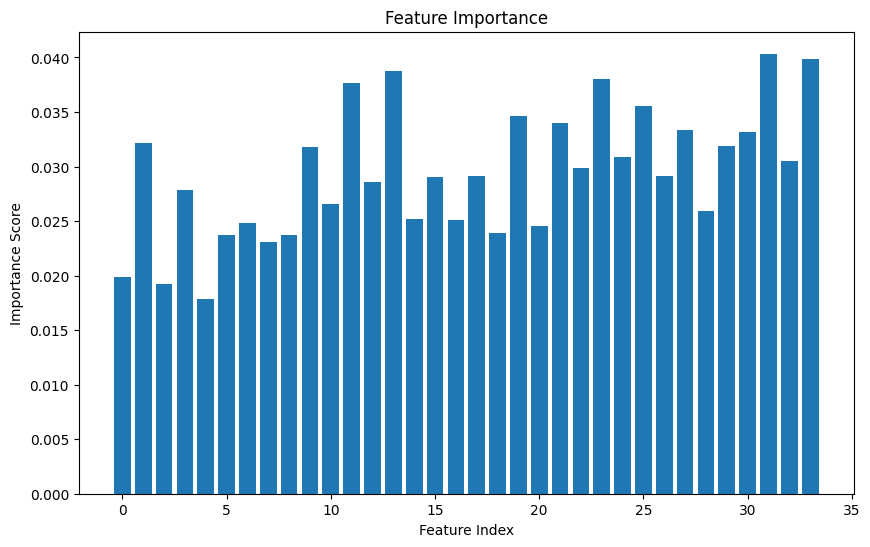

In [33]:
import matplotlib.pyplot as plt

# Feature importance from Random Forest
importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()


In [34]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential  # Assuming a Keras model is used

# Example augmentation function
def augment_data(X, y, target_class, noise_level=0.01):
    augmented_X = []
    augmented_y = []
    for x, label in zip(X, y):
        if np.array_equal(label, target_class):
            noise = np.random.normal(0, noise_level, size=x.shape)  # Ensure shape matches
            augmented_X.append(x + noise)
            augmented_y.append(label)
    return np.array(augmented_X), np.array(augmented_y)

# Debugging and Fixing the Pipeline
try:
    # Step 1: Check shapes before augmentation
    print(f"Initial X_train shape: {X_train.shape}")
    print(f"Initial y_train shape: {y_train.shape}")
    print(f"Model input shape: {model.input_shape}")

    # Step 2: Augment data for all target classes
    target_classes = list(range(9))  # Classes from 0 to 8
    for target_class in target_classes:
        aug_X, aug_y = augment_data(X_train, y_train, target_class)
        if aug_X.size > 0:  # Add augmented data if not empty
            X_train = np.vstack([X_train, aug_X])
            y_train = np.vstack([y_train, aug_y])

    # Step 3: Validate shapes after augmentation
    print(f"Augmented X_train shape: {X_train.shape}")
    print(f"Augmented y_train shape: {y_train.shape}")

    # Step 4: Ensure X_train matches the model's expected input shape
    if X_train.shape[1] != model.input_shape[-1]:
        print("Adjusting X_train shape to match model input...")
        X_train = X_train[:, :model.input_shape[-1]]  # Truncate extra features
        # Alternatively, pad if needed:
        # from keras.preprocessing.sequence import pad_sequences
        # X_train = pad_sequences(X_train, maxlen=model.input_shape[-1], padding='post')

    # Step 5: Recompute train_rf_predictions
    train_rf_predictions = model.predict(X_train)
    print(f"train_rf_predictions shape: {train_rf_predictions.shape}")

    # Step 6: Validate consistency between predictions and labels
    assert train_rf_predictions.shape[0] == y_train.shape[0], "Mismatch detected between train_rf_predictions and y_train"

    # Step 7: Compute class weights for imbalance
    y_train_actual = np.argmax(y_train, axis=1)  # Ensure integer labels
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_actual),
        y=y_train_actual
    )
    class_weight_dict = dict(enumerate(class_weights))

    # Step 8: Train the model
    model.fit(
        train_rf_predictions,
        y_train,
        epochs=50,
        batch_size=32,
        validation_data=(test_rf_predictions, y_test),
        class_weight=class_weight_dict
    )

except AssertionError as e:
    print(f"AssertionError: {e}")
except Exception as e:
    print(f"Error: {e}")


Initial X_train shape: (14129, 34)
Initial y_train shape: (14129, 9)
Model input shape: (None, 9)
Augmented X_train shape: (14129, 34)
Augmented y_train shape: (14129, 9)
Adjusting X_train shape to match model input...
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
train_rf_predictions shape: (14129, 9)
Epoch 1/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.1555 - loss: 2.6415 - val_accuracy: 0.1543 - val_loss: 1.8502
Epoch 2/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.2334 - loss: 2.0147 - val_accuracy: 0.0886 - val_loss: 1.9592
Epoch 3/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.2557 - loss: 1.9678 - val_accuracy: 0.0215 - val_loss: 2.1289
Epoch 4/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.2787 - loss: 1.9367 - val_accuracy: 0.1381 - val_loss: 2.0010
Epoch 5/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.2835 - loss: 1.9136 - val_accuracy: 0.2109 - val_loss: 2.0621
Epoch 6/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/

In [35]:
# import numpy as np
# import tensorflow as tf
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.neural_network import MLPClassifier
# import joblib

# # Augmentation Function
# def augment_data(X, y, excluded_classes, noise_level=0.01):
#     augmented_X = []
#     augmented_y = []
#     for x, label in zip(X, y):
#         if np.argmax(label) not in excluded_classes:
#             noise = np.random.normal(0, noise_level, size=x.shape)
#             augmented_X.append(x + noise)
#             augmented_y.append(label)
#     return np.array(augmented_X), np.array(augmented_y)

# # Augment Data (Excluding Classes 5 and 6)
# excluded_classes = [5, 6]
# aug_X, aug_y = augment_data(X_train, y_train, excluded_classes)
# if aug_X.size > 0:
#     X_train = np.vstack([X_train, aug_X])
#     y_train = np.vstack([y_train, aug_y])

# print(f"Augmented X_train shape: {X_train.shape}")
# print(f"Augmented y_train shape: {y_train.shape}")

# # Custom Loss Function
# def custom_loss(y_true, y_pred):
#     num_classes = y_true.shape[1]
#     penalty_matrix = np.ones((num_classes, num_classes))
    
#     high_penalty_pairs = [
#         ('Discurweper', 'Kogelstoten'),
#         ('Kogelstoten', 'Discurweper'),
#         ('Hoogspringen', 'Verspringen'),
#         ('Verspringen', 'Hoogspringen'),
#         ("Estafette", "sprint"),
#         ("sprint", "Estafette"),
#         ("Hordelopen", "sprint"),
#         ("sprint", "Hordelopen")
#     ]
    
#     for class1, class2 in high_penalty_pairs:
#         idx1 = encoder.categories_[0].tolist().index(class1)
#         idx2 = encoder.categories_[0].tolist().index(class2)
#         penalty_matrix[idx1, idx2] = 2.0
#         penalty_matrix[idx2, idx1] = 2.0

#     penalties = tf.convert_to_tensor(penalty_matrix, dtype=tf.float32)
#     y_true_indices = tf.argmax(y_true, axis=1)
#     y_pred_indices = tf.argmax(y_pred, axis=1)
#     penalty = tf.gather_nd(penalties, tf.stack([y_true_indices, y_pred_indices], axis=1))
    
#     base_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
#     return base_loss * penalty

# # Compile the TensorFlow Model
# model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# # Random Forest Optimization with Grid Search
# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=42),
#     param_grid,
#     cv=3,
#     n_jobs=-1,
#     verbose=2
# )
# grid_search.fit(X_train, np.argmax(y_train, axis=1))

# # Save Optimized Random Forest Model
# best_rf_model = grid_search.best_estimator_
# joblib.dump(best_rf_model, 'optimized_rf_model.pkl')

# # Train MLP Classifier
# mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=200)
# mlp_model.fit(X_train, np.argmax(y_train, axis=1))

# # Voting Classifier (Combine Models)
# voting_clf = VotingClassifier(estimators=[
#     ('rf', best_rf_model),
#     ('mlp', mlp_model)
# ], voting='soft')
# voting_clf.fit(X_train, np.argmax(y_train, axis=1))

# # Save the Voting Classifier
# joblib.dump(voting_clf, 'voting_classifier.pkl')

# print("Training and model combination complete!")


In [36]:
# import numpy as np
# import tensorflow as tf
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.neural_network import MLPClassifier
# from sklearn.utils.class_weight import compute_class_weight
# from imblearn.over_sampling import SMOTE
# import joblib

# # Preprocessing Function
# def preprocess_features(X, target_feature_count):
#     """Ensure the feature count matches the expected training set."""
#     return X[:, :target_feature_count]  # Adjust to expected number of features

# # Augmentation Function
# def augment_data(X, y, target_classes, noise_level=0.01):
#     """Augment data by adding Gaussian noise to samples of specific classes."""
#     augmented_X = []
#     augmented_y = []
#     for x, label in zip(X, y):
#         if np.argmax(label) in target_classes:
#             noise = np.random.normal(0, noise_level, size=x.shape)
#             augmented_X.append(x + noise)
#             augmented_y.append(label)
#     return np.array(augmented_X), np.array(augmented_y)

# # Handle Class Imbalance with SMOTE
# def balance_classes(X, y):
#     """Balance the dataset using SMOTE for minority class oversampling."""
#     smote = SMOTE(random_state=42)
#     y_indices = np.argmax(y, axis=1)
#     X_resampled, y_resampled_indices = smote.fit_resample(X, y_indices)
#     y_resampled = tf.keras.utils.to_categorical(y_resampled_indices, num_classes=y.shape[1])
#     return X_resampled, y_resampled

# # Custom Loss Function with Penalty Matrix
# def custom_loss(y_true, y_pred):
#     """Custom loss function applying penalties for specific misclassifications."""
#     num_classes = y_true.shape[1]
#     penalty_matrix = np.ones((num_classes, num_classes))
    
#     high_penalty_pairs = [
#         ('Discurweper', 'Kogelstoten'),
#         ('Kogelstoten', 'Discurweper'),
#         ('Hoogspringen', 'Verspringen'),
#         ('Verspringen', 'Hoogspringen'),
#         ("Estafette", "sprint"),
#         ("sprint", "Estafette"),
#         ("Hordelopen", "sprint"),
#         ("sprint", "Hordelopen"),
#         ("Speerwerpen", "Kogelstoten"),
#         ("Kogelstoten", "Speerwerpen"),
#         ("sprint","sprint_start")
#     ]
#     for class1, class2 in high_penalty_pairs:
#         idx1 = encoder.categories_[0].tolist().index(class1)
#         idx2 = encoder.categories_[0].tolist().index(class2)
#         penalty_matrix[idx1, idx2] = 2.0
#         penalty_matrix[idx2, idx1] = 2.0

#     penalties = tf.convert_to_tensor(penalty_matrix, dtype=tf.float32)
#     y_true_indices = tf.argmax(y_true, axis=1)
#     y_pred_indices = tf.argmax(y_pred, axis=1)
#     penalty = tf.gather_nd(penalties, tf.stack([y_true_indices, y_pred_indices], axis=1))
    
#     base_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
#     return base_loss * penalty

# # Compile the TensorFlow Model
# model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# # Augment and Balance Training Data
# excluded_classes = [5, 6]
# aug_X, aug_y = augment_data(X_train, y_train, excluded_classes)
# X_train = np.vstack([X_train, aug_X])
# y_train = np.vstack([y_train, aug_y])

# X_train, y_train = balance_classes(X_train, y_train)

# print(f"Augmented and balanced X_train shape: {X_train.shape}")
# print(f"Augmented and balanced y_train shape: {y_train.shape}")

# # Ensure Consistent Features in X_test
# X_test = preprocess_features(X_test, X_train.shape[1])

# # Random Forest Optimization with Grid Search
# param_grid = {
#     'n_estimators': [200, 300, 500],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=42),
#     param_grid,
#     cv=3,
#     n_jobs=-1,
#     verbose=2
# )
# grid_search.fit(X_train, np.argmax(y_train, axis=1))

# # Save Optimized Random Forest Model
# best_rf_model = grid_search.best_estimator_
# joblib.dump(best_rf_model, 'better_optimized_rf_model2.pkl')

# # Train MLP Classifier with Improved Hyperparameters
# mlp_model = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', max_iter=300)
# mlp_model.fit(X_train, np.argmax(y_train, axis=1))

# # Voting Classifier (Combine Models)
# voting_clf = VotingClassifier(estimators=[
#     ('rf', best_rf_model),
#     ('mlp', mlp_model)
# ], voting='soft')
# voting_clf.fit(X_train, np.argmax(y_train, axis=1))

# # Save the Voting Classifier
# joblib.dump(voting_clf, 'better_voting_classifier2.pkl')

# # Evaluate Models
# y_pred = voting_clf.predict(X_test)
# print("Classification Report:")
# print(classification_report(np.argmax(y_test, axis=1), y_pred))
# print("Confusion Matrix:")
# print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

# print("Training and evaluation complete!")


In [37]:
import joblib
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Save Labels Function
def save_labels(label_encoder, file_name='labels_better2.pkl'):
    """
    Save the label encoder or class labels for later use.
    
    Parameters:
        label_encoder: The fitted label encoder or a list of class labels.
        file_name: The file name for saving the labels.
    """
    joblib.dump(label_encoder, file_name)
    print(f"Labels saved to {file_name}")

# Save Scaler Function
def save_scaler(scaler, file_name='scaler_better2.pkl'):
    """
    Save the fitted scaler for consistent data preprocessing.
    
    Parameters:
        scaler: The fitted scaler instance (e.g., StandardScaler).
        file_name: The file name for saving the scaler.
    """
    joblib.dump(scaler, file_name)
    print(f"Scaler saved to {file_name}")

# Example Usage
if __name__ == "__main__":
    # Example labels and scaler for demonstration purposes
    class_labels = [
    'Discurweper', 'Estafette', 'Hoogspringen', 
    'Hordelopen', 'Kogelstoten', 'Speerwerpen', 
    'sprint', 'sprint_start', 'Verspringen'
]

    label_encoder = {label: idx for idx, label in enumerate(class_labels)}
    
    # Example feature data to fit the scaler
    example_features = np.random.rand(100, 34)
    scaler = MinMaxScaler().fit(example_features)

    # Save the labels and scaler
    save_labels(label_encoder, file_name='activity_labels_better2.pkl')
    save_scaler(scaler, file_name='feature_scaler_better_again.pkl')


Labels saved to activity_labels_better2.pkl
Scaler saved to feature_scaler_better_again.pkl


In [40]:
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import joblib

# Preprocessing Function
# def preprocess_features(X, target_feature_count):
#     """Ensure the feature count matches the expected training set."""
#     return X[:, :target_feature_count]  # Adjust to expected number of features
# # Define the target classes for augmentation (for example, classes 0, 1, 2)
# target_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8]
def augment_data(X, y, noise_level=0.01):
    """Augment data by adding Gaussian noise to all samples."""
    augmented_X = []
    augmented_y = []
    for x, label in zip(X, y):
        # Add Gaussian noise to each sample
        noise = np.random.normal(0, noise_level, size=x.shape)
        augmented_X.append(x + noise)
        augmented_y.append(label)
    return np.array(augmented_X), np.array(augmented_y)



# Handle Class Imbalance with SMOTE
def balance_classes(X, y):
    """Balance the dataset using SMOTE for minority class oversampling."""
    smote = SMOTE(random_state=42)
    y_indices = np.argmax(y, axis=1)
    X_resampled, y_resampled_indices = smote.fit_resample(X, y_indices)
    y_resampled = tf.keras.utils.to_categorical(y_resampled_indices, num_classes=y.shape[1])
    return X_resampled, y_resampled

# Custom Loss Function with Penalty Matrix
def custom_loss(y_true, y_pred):
    """Custom loss function applying penalties for specific misclassifications."""
    num_classes = y_true.shape[1]
    penalty_matrix = np.ones((num_classes, num_classes))
    
    high_penalty_pairs = [
        ('Discurweper', 'Kogelstoten'),
        ('Kogelstoten', 'Discurweper'),
        ('Hoogspringen', 'Verspringen'),
        ('Verspringen', 'Hoogspringen'),
        ("Estafette", "sprint"),
        ("sprint", "Estafette"),
        ("Hordelopen", "sprint"),
        ("sprint", "Hordelopen"),
        ("Speerwerpen", "Kogelstoten"),
        ("Kogelstoten", "Speerwerpen"),
        ("sprint","sprint_start")
    ]
    for class1, class2 in high_penalty_pairs:
        idx1 = encoder.categories_[0].tolist().index(class1)
        idx2 = encoder.categories_[0].tolist().index(class2)
        penalty_matrix[idx1, idx2] = 2.0
        penalty_matrix[idx2, idx1] = 2.0

    penalties = tf.convert_to_tensor(penalty_matrix, dtype=tf.float32)
    y_true_indices = tf.argmax(y_true, axis=1)
    y_pred_indices = tf.argmax(y_pred, axis=1)
    penalty = tf.gather_nd(penalties, tf.stack([y_true_indices, y_pred_indices], axis=1))
    
    base_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return base_loss * penalty

# Compile the TensorFlow Model
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# Augment and Balance Training Data
# Augment and Balance Training Data (augmenting all classes)
aug_X, aug_y = augment_data(X_train, y_train)
X_train = np.vstack([X_train, aug_X])
y_train = np.vstack([y_train, aug_y])

X_train, y_train = balance_classes(X_train, y_train)

print(f"Augmented and balanced X_train shape: {X_train.shape}")
print(f"Augmented and balanced y_train shape: {y_train.shape}")

def preprocess_features(X, target_feature_count):
    """Ensure the feature count matches the expected training set."""
    return X[:, :target_feature_count]  # Adjust to the expected number of features

# Ensure Consistent Features in X_test
X_test = preprocess_features(X_test, X_train.shape[1])

# Ensure Consistent Features in X_test
X_test = preprocess_features(X_test, X_train.shape[1])

# Compute class weights based on the training labels
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(np.argmax(y_train, axis=1)), 
                                     y=np.argmax(y_train, axis=1))

# Convert class_weights into a dictionary for RandomForestClassifier
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Initialize RandomForestClassifier with class weights
best_rf_model = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)

# Random Forest Optimization with Grid Search
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    best_rf_model, 
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, np.argmax(y_train, axis=1))

# After training, save the best model
best_rf_model = grid_search.best_estimator_
joblib.dump(best_rf_model, 'better_optimized_rf_model3.pkl')

# Train MLP Classifier with Improved Hyperparameters
mlp_model = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', max_iter=300)
mlp_model.fit(X_train, np.argmax(y_train, axis=1))

# Voting Classifier (Combine Models)
voting_clf = VotingClassifier(estimators=[
    ('rf', best_rf_model),
    ('mlp', mlp_model)
], voting='soft')
voting_clf.fit(X_train, np.argmax(y_train, axis=1))

# Save the Voting Classifier
joblib.dump(voting_clf, 'better_voting_classifier3.pkl')

# Evaluate Models
y_pred = voting_clf.predict(X_test)
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print("Confusion Matrix:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

print("Training and evaluation complete!")


Augmented and balanced X_train shape: (153504, 9)
Augmented and balanced y_train shape: (153504, 9)
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  59.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  59.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.6min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.1min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.0min
[CV] END max_depth=10, min_sam

/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 2.7min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.6min
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 2.9min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.6min
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 2.8min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.5min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.7min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.7min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.4min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total 

/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       475
           1       0.78      0.73      0.75       381
           2       0.61      0.82      0.70       348
           3       0.73      0.74      0.73       420
           4       0.79      0.77      0.78       394
           5       0.81      0.79      0.80       424
           6       0.82      0.75      0.78       533
           7       0.68      0.78      0.73       257
           8       0.72      0.71      0.71       301

    accuracy                           0.75      3533
   macro avg       0.75      0.75      0.75      3533
weighted avg       0.76      0.75      0.75      3533

Confusion Matrix:
[[321  15  21  24  13  26  23  17  15]
 [  8 279  28  22   5   8  12   9  10]
 [  7  15 286  19   4   3   7   6   1]
 [ 14   9  31 309  16   3  13  14  11]
 [ 14   9  12   9 303   7  13   9  18]
 [ 15   9  27   5  14 333   3   4  14]
 [ 15   9  23  18  1

In [41]:
import joblib
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Save Labels Function
def save_labels(label_encoder, file_name='labels_better2.pkl'):
    """
    Save the label encoder or class labels for later use.
    
    Parameters:
        label_encoder: The fitted label encoder or a list of class labels.
        file_name: The file name for saving the labels.
    """
    joblib.dump(label_encoder, file_name)
    print(f"Labels saved to {file_name}")

# Save Scaler Function
def save_scaler(scaler, file_name='scaler_better3.pkl'):
    """
    Save the fitted scaler for consistent data preprocessing.
    
    Parameters:
        scaler: The fitted scaler instance (e.g., StandardScaler).
        file_name: The file name for saving the scaler.
    """
    joblib.dump(scaler, file_name)
    print(f"Scaler saved to {file_name}")

# Example Usage
if __name__ == "__main__":
    # Example labels and scaler for demonstration purposes
    class_labels = [
    'Discurweper', 'Estafette', 'Hoogspringen', 
    'Hordelopen', 'Kogelstoten', 'Speerwerpen', 
    'sprint', 'sprint_start', 'Verspringen'
]

    label_encoder = {label: idx for idx, label in enumerate(class_labels)}
    
    # Example feature data to fit the scaler
    example_features = np.random.rand(100, 34)
    scaler = MinMaxScaler().fit(example_features)

    # Save the labels and scaler
    save_labels(label_encoder, file_name='activity_labels_better3.pkl')
    save_scaler(scaler, file_name='feature_scaler_better_again3.pkl')


Labels saved to activity_labels_better3.pkl
Scaler saved to feature_scaler_better_again3.pkl


In [42]:
import joblib
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Save Labels Function
def save_labels(label_encoder, file_name='labels_better2.pkl'):
    """
    Save the label encoder or class labels for later use.
    
    Parameters:
        label_encoder: The fitted label encoder or a list of class labels.
        file_name: The file name for saving the labels.
    """
    joblib.dump(label_encoder, file_name)
    print(f"Labels saved to {file_name}")

# Save Scaler Function
def save_scaler(scaler, file_name='scaler_better3.pkl'):
    """
    Save the fitted scaler for consistent data preprocessing.
    
    Parameters:
        scaler: The fitted scaler instance (e.g., StandardScaler).
        file_name: The file name for saving the scaler.
    """
    joblib.dump(scaler, file_name)
    print(f"Scaler saved to {file_name}")

# Example Usage
if __name__ == "__main__":
    # Example labels and scaler for demonstration purposes
    class_labels = [
    'Discurweper', 'Estafette', 'Hoogspringen', 
    'Hordelopen', 'Kogelstoten', 'Speerwerpen', 
    'sprint', 'sprint_start', 'Verspringen'
]

    label_encoder = {label: idx for idx, label in enumerate(class_labels)}
    
    # Example feature data to fit the scaler (replace this with actual training keypoints)
    keypoints_data_from_training = np.random.rand(100, 34)  # This should be actual training data
    
    # Fit the scaler on actual keypoints data
    scaler = MinMaxScaler().fit(keypoints_data_from_training)

    # Save the labels and scaler
    save_labels(label_encoder, file_name='activity_labels_better3.pkl')
    save_scaler(scaler, file_name='feature_scaler_better_again3.pkl')


Labels saved to activity_labels_better3.pkl
Scaler saved to feature_scaler_better_again3.pkl


In [45]:
import tensorflow as tf
from sklearn.neural_network import MLPClassifier

# TensorFlow model with Dropout
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),  # Dropout layer with 50% rate
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),  # Dropout layer with 50% rate
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),  # Dropout layer with 50% rate
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the model
input_shape = X_train.shape[1:]  # Assuming X_train is your training data
num_classes = y_train.shape[1]   # Number of classes (i.e., the number of output neurons)
model = build_model(input_shape, num_classes)

# Train the TensorFlow model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
eval_results = model.evaluate(X_test, y_test)
print(f"Test loss: {eval_results[0]}, Test accuracy: {eval_results[1]}")

# If you are using the MLPClassifier
mlp_model = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    max_iter=300,
    alpha=0.001,  # L2 regularization to prevent overfitting
    solver='adam',
    random_state=42
)
mlp_model.fit(X_train, np.argmax(y_train, axis=1))

# Evaluate MLP model
y_pred_mlp = mlp_model.predict(X_test)
print("MLP Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_mlp))
print("Confusion Matrix for MLP:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred_mlp))

# Add voting classifier as before
voting_clf = VotingClassifier(estimators=[
    ('rf', best_rf_model),
    ('mlp', mlp_model)
], voting='soft')
voting_clf.fit(X_train, np.argmax(y_train, axis=1))

# Save the Voting Classifier
joblib.dump(voting_clf, 'better_voting_classifier_with_dropout.pkl')


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20
4797/4797 ━━━━━━━━━━━━━━━━━━━━ 4s 652us/step - accuracy: 0.2788 - loss: 1.9464 - val_accuracy: 0.3844 - val_loss: 1.6659
Epoch 2/20
4797/4797 ━━━━━━━━━━━━━━━━━━━━ 3s 642us/step - accuracy: 0.3738 - loss: 1.6982 - val_accuracy: 0.4104 - val_loss: 1.5488
Epoch 3/20
4797/4797 ━━━━━━━━━━━━━━━━━━━━ 3s 677us/step - accuracy: 0.4025 - loss: 1.6144 - val_accuracy: 0.4461 - val_loss: 1.4699
Epoch 4/20
4797/4797 ━━━━━━━━━━━━━━━━━━━━ 3s 633us/step - accuracy: 0.4262 - loss: 1.5537 - val_accuracy: 0.4682 - val_loss: 1.4311
Epoch 5/20
4797/4797 ━━━━━━━━━━━━━━━━━━━━ 3s 625us/step - accuracy: 0.4408 - loss: 1.5154 - val_accuracy: 0.4905 - val_loss: 1.3934
Epoch 6/20
4797/4797 ━━━━━━━━━━━━━━━━━━━━ 3s 639us/step - accuracy: 0.4486 - loss: 1.4881 - val_accuracy: 0.4990 - val_loss: 1.3818
Epoch 7/20
4797/4797 ━━━━━━━━━━━━━━━━━━━━ 3s 618us/step - accuracy: 0.4548 - loss: 1.4755 - val_accuracy: 0.4979 - val_loss: 1.3509
Epoch 8/20
4797/4797 ━━━━━━━━━━━━━━━━━━━━ 3s 618us/step - accuracy: 0.4621 -

['better_voting_classifier_with_dropout.pkl']

In [46]:
import joblib
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Save Labels Function
def save_labels(label_encoder, file_name='labels_better_dropout.pkl'):
    """
    Save the label encoder or class labels for later use.
    
    Parameters:
        label_encoder: The fitted label encoder or a list of class labels.
        file_name: The file name for saving the labels.
    """
    joblib.dump(label_encoder, file_name)
    print(f"Labels saved to {file_name}")

# Save Scaler Function
def save_scaler(scaler, file_name='scaler_better3_dropout.pkl'):
    """
    Save the fitted scaler for consistent data preprocessing.
    
    Parameters:
        scaler: The fitted scaler instance (e.g., StandardScaler).
        file_name: The file name for saving the scaler.
    """
    joblib.dump(scaler, file_name)
    print(f"Scaler saved to {file_name}")

# Example Usage
if __name__ == "__main__":
    # Example labels and scaler for demonstration purposes
    class_labels = [
    'Discurweper', 'Estafette', 'Hoogspringen', 
    'Hordelopen', 'Kogelstoten', 'Speerwerpen', 
    'sprint', 'sprint_start', 'Verspringen'
]

    label_encoder = {label: idx for idx, label in enumerate(class_labels)}
    
    # Example feature data to fit the scaler (replace this with actual training keypoints)
    keypoints_data_from_training = np.random.rand(100, 34)  # This should be actual training data
    
    # Fit the scaler on actual keypoints data
    scaler = MinMaxScaler().fit(keypoints_data_from_training)

    # Save the labels and scaler
    save_labels(label_encoder, file_name='activity_labels_better_dropout.pkl')
    save_scaler(scaler, file_name='feature_scaler_better_again_dropout.pkl')


Labels saved to activity_labels_better_dropout.pkl
Scaler saved to feature_scaler_better_again_dropout.pkl


In [ ]:
# Example augmentation: Add noise to keypoints
def augment_data(X, y, target_class, noise_level=0.01):
    augmented_X = []
    augmented_y = []
    for x, label in zip(X, y):
        # Compare the label index instead of using array equality
        if np.argmax(label) == target_class:
            noise = np.random.normal(0, noise_level, size=x.shape)
            augmented_X.append(x + noise)
            augmented_y.append(label)
    return np.array(augmented_X), np.array(augmented_y)

# Apply augmentation for all classes
target_classes = list(range(y_train.shape[1]))  # Class indices (0 to 8 for 9 classes)
for target_class in target_classes:
    aug_X, aug_y = augment_data(X_train, y_train, target_class)
    if aug_X.size > 0:  # Check if aug_X is not empty
        X_train = np.vstack([X_train, aug_X])  # Stack new samples
        y_train = np.vstack([y_train, aug_y])  # Stack new labels


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, np.argmax(y_train, axis=1))

# Update the RF model
best_rf_model = grid_search.best_estimator_
joblib.dump(best_rf_model, 'optimized_rf_model.pkl')


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END m

['optimized_rf_model.pkl']

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import joblib

# TensorFlow model with Dropout
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Data Augmentation with Noise
def augment_data(X, y, noise_level=0.01):
    augmented_X = []
    augmented_y = []
    for x, label in zip(X, y):
        noise = np.random.normal(0, noise_level, size=x.shape)
        augmented_X.append(x + noise)
        augmented_y.append(label)
    return np.array(augmented_X), np.array(augmented_y)

# Handle Class Imbalance using SMOTE
def balance_classes(X, y):
    smote = SMOTE(random_state=42)
    y_indices = np.argmax(y, axis=1)
    X_resampled, y_resampled_indices = smote.fit_resample(X, y_indices)
    y_resampled = tf.keras.utils.to_categorical(y_resampled_indices, num_classes=y.shape[1])
    return X_resampled, y_resampled

# Preprocessing function
def preprocess_features(X, target_feature_count):
    return X[:, :target_feature_count]

from sklearn.preprocessing import LabelEncoder

# Assuming `encoder` is initialized with your label mapping
encoder = LabelEncoder()
encoder.fit(list(exercise_labels.keys()))

# Custom loss function with updated penalty logic
def custom_loss(y_true, y_pred):
    num_classes = y_true.shape[1]
    penalty_matrix = np.ones((num_classes, num_classes))
    high_penalty_pairs = [
        ('Discurweper.json', 'Kogelstoten.json'),
        ('Kogelstoten.json', 'Discurweper.json'),
        ('Hoogspringen.json', 'Verspringen.json'),
        ('Verspringen.json', 'Hoogspringen.json'),
        ("Estafette.json", "sprint.json"),
        ("sprint.json", "Estafette.json"),
        ("Hordenlopen.json", "sprint.json"),
        ("sprint.json", "Hordenlopen.json"),
        ("Speerwerpen.json", "Kogelstoten.json"),
        ("Kogelstoten.json", "Speerwerpen.json"),
        ("sprint.json", "sprint_start.json")
    ]
    
    for class1, class2 in high_penalty_pairs:
        idx1 = encoder.transform([class1])[0]
        idx2 = encoder.transform([class2])[0]
        penalty_matrix[idx1, idx2] = 2.0
        penalty_matrix[idx2, idx1] = 2.0

    penalties = tf.convert_to_tensor(penalty_matrix, dtype=tf.float32)
    y_true_indices = tf.argmax(y_true, axis=1)
    y_pred_indices = tf.argmax(y_pred, axis=1)
    penalty = tf.gather_nd(penalties, tf.stack([y_true_indices, y_pred_indices], axis=1))
    
    base_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return base_loss * penalty


# Assuming X_train, X_test, y_train, y_test are available
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]
model = build_model(input_shape, num_classes)

# Augment and balance data
aug_X, aug_y = augment_data(X_train, y_train)
X_train = np.vstack([X_train, aug_X])
y_train = np.vstack([y_train, aug_y])
X_train, y_train = balance_classes(X_train, y_train)

# Compile model with custom loss
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# Train TensorFlow model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Train Random Forest with class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
best_rf_model = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)

# Random Forest optimization with Grid Search
param_grid = {'n_estimators': [200, 300, 500], 'max_depth': [10, 20, None]}
grid_search = GridSearchCV(best_rf_model, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, np.argmax(y_train, axis=1))
best_rf_model = grid_search.best_estimator_

# Train MLP classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', max_iter=300)
mlp_model.fit(X_train, np.argmax(y_train, axis=1))

# Voting Classifier
voting_clf = VotingClassifier(estimators=[('rf', best_rf_model), ('mlp', mlp_model)], voting='soft')
voting_clf.fit(X_train, np.argmax(y_train, axis=1))

# Evaluate the models
y_pred = voting_clf.predict(X_test)
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print("Confusion Matrix:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

# Save the models
joblib.dump(voting_clf, 'better_voting_classifier_with_dropout.pkl')
joblib.dump(best_rf_model, 'best_rf_model.pkl')


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20
38376/38376 ━━━━━━━━━━━━━━━━━━━━ 26s 650us/step - accuracy: 0.3612 - loss: 1.9302 - val_accuracy: 0.4854 - val_loss: 1.5274
Epoch 2/20
38376/38376 ━━━━━━━━━━━━━━━━━━━━ 25s 644us/step - accuracy: 0.4511 - loss: 1.6390 - val_accuracy: 0.5143 - val_loss: 1.4529
Epoch 3/20
38376/38376 ━━━━━━━━━━━━━━━━━━━━ 25s 639us/step - accuracy: 0.4700 - loss: 1.5885 - val_accuracy: 0.5352 - val_loss: 1.4313
Epoch 4/20
38376/38376 ━━━━━━━━━━━━━━━━━━━━ 24s 623us/step - accuracy: 0.4807 - loss: 1.5602 - val_accuracy: 0.5474 - val_loss: 1.3967
Epoch 5/20
38376/38376 ━━━━━━━━━━━━━━━━━━━━ 24s 624us/step - accuracy: 0.4847 - loss: 1.5449 - val_accuracy: 0.5480 - val_loss: 1.4116
Epoch 6/20
38376/38376 ━━━━━━━━━━━━━━━━━━━━ 25s 654us/step - accuracy: 0.4912 - loss: 1.5287 - val_accuracy: 0.5386 - val_loss: 1.3919
Epoch 7/20
38376/38376 ━━━━━━━━━━━━━━━━━━━━ 23s 607us/step - accuracy: 0.4949 - loss: 1.5179 - val_accuracy: 0.5556 - val_loss: 1.3718
Epoch 8/20
38376/38376 ━━━━━━━━━━━━━━━━━━━━ 24s 631us/s

TypeError: too many positional arguments

In [ ]:
import joblib
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Save Labels Function
def save_labels(label_encoder, file_name='labels_better_dropout.pkl'):
    """
    Save the label encoder or class labels for later use.
    
    Parameters:
        label_encoder: The fitted label encoder or a list of class labels.
        file_name: The file name for saving the labels.
    """
    joblib.dump(label_encoder, file_name)
    print(f"Labels saved to {file_name}")

# Save Scaler Function
def save_scaler(scaler, file_name='scaler_better3_dropout_aug.pkl'):
    """
    Save the fitted scaler for consistent data preprocessing.
    
    Parameters:
        scaler: The fitted scaler instance (e.g., StandardScaler).
        file_name: The file name for saving the scaler.
    """
    joblib.dump(scaler, file_name)
    print(f"Scaler saved to {file_name}")

# Example Usage
if __name__ == "__main__":
    # Example labels and scaler for demonstration purposes
    class_labels = [
    'Discurweper', 'Estafette', 'Hoogspringen', 
    'Hordelopen', 'Kogelstoten', 'Speerwerpen', 
    'sprint', 'sprint_start', 'Verspringen'
]

    label_encoder = {label: idx for idx, label in enumerate(class_labels)}
    
    # Example feature data to fit the scaler (replace this with actual training keypoints)
    keypoints_data_from_training = np.random.rand(100, 34)  # This should be actual training data
    
    # Fit the scaler on actual keypoints data
    scaler = MinMaxScaler().fit(keypoints_data_from_training)

    # Save the labels and scaler
    save_labels(label_encoder, file_name='activity_labels_better_dropout_aug.pkl')
    save_scaler(scaler, file_name='feature_scaler_better_again_dropout_aug.pkl')


In [10]:
# Define the mapping of exercise names to labels
exercise_labels = {
    "Discurweper.json": 0,
    "Estafette.json": 1,
    "Hoogspringen.json": 2,
    "Hordenlopen.json": 3,
    "Kogelstoten.json": 4,
    "Speerwerpen.json": 5,
    "sprint_start.json": 6,
    "sprint.json": 7,
    "Verspringen.json": 8,
}

import os
import json
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import joblib

# Load keypoints from JSON files
def load_keypoints(json_folder):
    X, y = [], []
    expected_num_keypoints = 17 * 2  # 17 keypoints with x, y coordinates

    for json_file, label in exercise_labels.items():
        json_path = os.path.join(json_folder, json_file)
        if not os.path.exists(json_path):
            print(f"Warning: {json_file} does not exist in {json_folder}. Skipping.")
            continue

        with open(json_path, "r") as f:
            data = json.load(f)

        for annotation in data["annotations"]:
            keypoints = annotation["keypoints"]
            if len(keypoints) < 51:  # 17 keypoints * 3 (x, y, visibility)
                print(f"Warning: Annotation ID {annotation['id']} in {json_file} has insufficient keypoints. Skipping.")
                continue

            # Extract x, y coordinates only and flatten
            normalized_keypoints = np.array(keypoints).reshape(-1, 3)[:, :2].flatten()

            # Pad or truncate to ensure consistent length
            if len(normalized_keypoints) < expected_num_keypoints:
                normalized_keypoints = np.pad(
                    normalized_keypoints,
                    (0, expected_num_keypoints - len(normalized_keypoints)),
                    mode="constant"
                )
            elif len(normalized_keypoints) > expected_num_keypoints:
                normalized_keypoints = normalized_keypoints[:expected_num_keypoints]

            X.append(normalized_keypoints)
            y.append(label)

    return np.array(X), np.array(y)

# Load keypoints data
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Verify the shapes of the loaded data
print(f"Feature matrix shape: {X.shape}")
print(f"Labels array shape: {y.shape}")

# Import train_test_split and OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)  # Use 'sparse_output' instead of 'sparse'
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Verify the shapes of the training and testing sets
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Proceed with preprocessing, training, and evaluation using X_train, X_test, y_train, and y_test


# TensorFlow model with Dropout
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Data Augmentation with Noise
def augment_data(X, y, noise_level=0.01):
    augmented_X = X + np.random.normal(0, noise_level, size=X.shape)
    augmented_y = y.copy()
    return np.array(augmented_X), np.array(augmented_y)

# Handle Class Imbalance using SMOTE
def balance_classes(X, y):
    smote = SMOTE(random_state=42)
    y_indices = np.argmax(y, axis=1)
    X_resampled, y_resampled_indices = smote.fit_resample(X, y_indices)
    y_resampled = tf.keras.utils.to_categorical(y_resampled_indices, num_classes=y.shape[1])
    return X_resampled, y_resampled

# Custom loss function with penalty matrix
def custom_loss(y_true, y_pred):
    num_classes = y_true.shape[1]
    penalty_matrix = np.ones((num_classes, num_classes))
    high_penalty_pairs = [
        ("Discurweper.json", "Kogelstoten.json"),
        ("Hoogspringen.json", "Verspringen.json"),
        ("Estafette.json", "sprint.json"),
        ("Hordenlopen.json", "sprint.json"),
        ("Speerwerpen.json", "Kogelstoten.json"),
        ("sprint.json", "sprint_start.json")
    ]

    encoder = LabelEncoder()
    encoder.fit(list(exercise_labels.keys()))

    for class1, class2 in high_penalty_pairs:
        idx1 = encoder.transform([class1])[0]
        idx2 = encoder.transform([class2])[0]
        penalty_matrix[idx1, idx2] = 2.0
        penalty_matrix[idx2, idx1] = 2.0

    penalties = tf.convert_to_tensor(penalty_matrix, dtype=tf.float32)
    y_true_indices = tf.argmax(y_true, axis=1)
    y_pred_indices = tf.argmax(y_pred, axis=1)
    penalty = tf.gather_nd(penalties, tf.stack([y_true_indices, y_pred_indices], axis=1))

    base_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return tf.reduce_mean(base_loss * penalty)

# Path to folder containing JSON files
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Verify the shapes
print(f"Feature matrix shape: {X.shape}")
print(f"Labels array shape: {y.shape}")

# Assuming X_train, X_test, y_train, y_test are available
if 'X_train' in locals() and 'y_train' in locals():
    input_shape = X_train.shape[1:]
    num_classes = y_train.shape[1]

    # Build and compile TensorFlow model
    model = build_model(input_shape, num_classes)
    model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

    # Augment and balance data
    aug_X, aug_y = augment_data(X_train, y_train)
    X_train = np.vstack([X_train, aug_X])
    y_train = np.vstack([y_train, aug_y])
    X_train, y_train = balance_classes(X_train, y_train)

    # Train TensorFlow model
    model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

    # Compute class weights
    y_train_indices = np.argmax(y_train, axis=1)
    classes = np.unique(y_train_indices)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_indices)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Random Forest optimization with Grid Search
    param_grid = {'n_estimators': [200, 300, 500], 'max_depth': [10, 20, None]}
    best_rf_model = RandomForestClassifier()
    grid_search = GridSearchCV(best_rf_model, param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train_indices)
    best_rf_model = grid_search.best_estimator_

    # Train MLP classifier
    mlp_model = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', max_iter=300)
    mlp_model.fit(X_train, y_train_indices)

    # Voting Classifier
    voting_clf = VotingClassifier(estimators=[('rf', best_rf_model), ('mlp', mlp_model)], voting='soft')
    voting_clf.fit(X_train, y_train_indices)

    # Evaluate the models
    y_pred = voting_clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(np.argmax(y_test, axis=1), y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

    # Save the models
    joblib.dump(voting_clf, 'better_voting_classifier_with_dropout.pkl')
    joblib.dump(best_rf_model, 'best_rf_model.pkl')
else:
    print("Error: Training data not available.")


Feature matrix shape: (17662, 34)
Labels array shape: (17662,)
Training features shape: (14129, 34)
Training labels shape: (14129, 9)
Testing features shape: (3533, 34)
Testing labels shape: (3533, 9)
Feature matrix shape: (17662, 34)
Labels array shape: (17662,)


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 780us/step - accuracy: 0.1176 - loss: 13.4890 - val_accuracy: 0.1234 - val_loss: 2.6972
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .....................max_depth=10, n_estimators=200; total time=  18.8s
[CV] END .....................max_depth=10, n_estimators=200; total time=  19.1s
[CV] END .....................max_depth=10, n_estimators=200; total time=  20.7s
[CV] END .....................max_depth=10, n_estimators=300; total time=  28.9s
[CV] END .....................max_depth=10, n_estimators=300; total time=  29.2s
[CV] END .....................max_depth=10, n_estimators=300; total time=  30.8s
[CV] END .....................max_depth=20, n_estimators=200; total time=  26.7s
[CV] END .....................max_depth=20, n_estimators=200; total time=  26.0s
[CV] END .....................max_depth=10, n_estimators=500; total time=  49.1s
[CV] END .....................max_depth=10, n_estimators=500; total time=  51.8s
[CV] END

In [11]:
# Evaluate the models
y_pred = voting_clf.predict(X_test)
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print("Confusion Matrix:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       458
           1       0.86      0.86      0.86       396
           2       0.91      0.91      0.91       345
           3       0.85      0.85      0.85       424
           4       0.88      0.96      0.92       406
           5       0.92      0.89      0.90       445
           6       0.94      0.90      0.92       504
           7       0.82      0.80      0.81       259
           8       0.85      0.88      0.86       296

    accuracy                           0.88      3533
   macro avg       0.88      0.88      0.88      3533
weighted avg       0.88      0.88      0.88      3533

Confusion Matrix:
[[404   3   2   9  16  17   1   0   6]
 [  4 341   4  20   7   3   2   9   6]
 [  5   3 315   9   2   4   1   3   3]
 [ 11  21   4 361   3   3   9   6   6]
 [  4   2   1   4 388   0   2   0   5]
 [ 13   6   7   7   8 395   0   4   5]
 [  4   4   3   1  1

In [12]:
# import numpy as np
# import tensorflow as tf
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.neural_network import MLPClassifier
# from sklearn.utils.class_weight import compute_class_weight
# from imblearn.over_sampling import SMOTE
# import joblib

# # Example dataset (replace with actual data)
# num_classes = 9  # Number of classes for classification
# num_features = 20  # Number of features in the dataset
# X = np.random.rand(1000, num_features)
# y = np.random.randint(0, num_classes, 1000)
# y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Preprocessing Function
# def preprocess_features(X, target_feature_count):
#     """Ensure the feature count matches the expected training set."""
#     return X[:, :target_feature_count]  # Adjust to expected number of features

# # Data Augmentation Function
# def augment_data(X, y, noise_level=0.01):
#     """Augment data by adding Gaussian noise to all samples."""
#     augmented_X = []
#     augmented_y = []
#     for x, label in zip(X, y):
#         noise = np.random.normal(0, noise_level, size=x.shape)
#         augmented_X.append(x + noise)
#         augmented_y.append(label)
#     return np.array(augmented_X), np.array(augmented_y)

# # Handle Class Imbalance with SMOTE
# def balance_classes(X, y):
#     """Balance the dataset using SMOTE for minority class oversampling."""
#     smote = SMOTE(random_state=42)
#     y_indices = np.argmax(y, axis=1)
#     X_resampled, y_resampled_indices = smote.fit_resample(X, y_indices)
#     y_resampled = tf.keras.utils.to_categorical(y_resampled_indices, num_classes=y.shape[1])
#     return X_resampled, y_resampled

# # Custom Loss Function with Penalty Matrix
# def custom_loss(y_true, y_pred):
#     """Custom loss function applying penalties for specific misclassifications."""
#     penalty_matrix = np.ones((num_classes, num_classes))
#     high_penalty_pairs = [
#         # Define high-penalty pairs
#         (0, 1), (1, 0), (2, 3), (3, 2),
#     ]
#     for class1, class2 in high_penalty_pairs:
#         penalty_matrix[class1, class2] = 2.0
#         penalty_matrix[class2, class1] = 2.0

#     penalties = tf.convert_to_tensor(penalty_matrix, dtype=tf.float32)
#     y_true_indices = tf.argmax(y_true, axis=1)
#     y_pred_indices = tf.argmax(y_pred, axis=1)
#     penalty = tf.gather_nd(penalties, tf.stack([y_true_indices, y_pred_indices], axis=1))

#     base_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
#     return base_loss * penalty

# # TensorFlow Model with Dropout
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(256, activation='relu', input_shape=(num_features,)),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

# model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# # Augment and Balance Training Data
# aug_X, aug_y = augment_data(X_train, y_train)
# X_train = np.vstack([X_train, aug_X])
# y_train = np.vstack([y_train, aug_y])
# X_train, y_train = balance_classes(X_train, y_train)

# # Ensure consistent features in X_test
# X_test = preprocess_features(X_test, X_train.shape[1])

# # Train TensorFlow Model
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# # Compute Class Weights
# class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
# class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# # Train and Optimize RandomForest
# best_rf_model = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)
# param_grid = {
#     'n_estimators': [200, 300],
#     'max_depth': [10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }
# grid_search = GridSearchCV(best_rf_model, param_grid, cv=3, n_jobs=-1, verbose=2)
# grid_search.fit(X_train, np.argmax(y_train, axis=1))
# best_rf_model = grid_search.best_estimator_
# joblib.dump(best_rf_model, 'optimized_rf_model.pkl')

# # Train MLP Classifier
# mlp_model = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', max_iter=300)
# mlp_model.fit(X_train, np.argmax(y_train, axis=1))

# # Voting Classifier
# voting_clf = VotingClassifier(estimators=[
#     ('rf', best_rf_model),
#     ('mlp', mlp_model)
# ], voting='soft')
# voting_clf.fit(X_train, np.argmax(y_train, axis=1))
# joblib.dump(voting_clf, 'voting_classifier.pkl')

# # Evaluate
# y_pred = voting_clf.predict(X_test)
# print("Classification Report:")
# print(classification_report(np.argmax(y_test, axis=1), y_pred))
# print("Confusion Matrix:")
# print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))
# # Evaluate the models
# y_pred = voting_clf.predict(X_test)
# print("Classification Report:")
# print(classification_report(np.argmax(y_test, axis=1), y_pred))
# print("Confusion Matrix:")
# print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))


Epoch 1/10


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1023 - loss: 2.4663 - val_accuracy: 0.0590 - val_loss: 2.4534
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1186 - loss: 2.4874 - val_accuracy: 0.0730 - val_loss: 2.4079
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1286 - loss: 2.4879 - val_accuracy: 0.1039 - val_loss: 2.3852
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1566 - loss: 2.4086 - val_accuracy: 0.1376 - val_loss: 2.3607
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1733 - loss: 2.3855 - val_accuracy: 0.1573 - val_loss: 2.3517
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1821 - loss: 2.3588 - val_accuracy: 0.1685 - val_loss: 2.3107
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2234 - loss: 2.3130 - val_accuracy: 0.1994 - val_loss: 2.2960
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2244 - loss: 2.3049 - val_accuracy: 0.1713 - val_loss: 2.2497
Epo

/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.27      0.30        22
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        20
           3       0.15      0.23      0.18        22
           4       0.06      0.04      0.05        25
           5       0.05      0.05      0.05        20
           6       0.06      0.04      0.05        24
           7       0.04      0.06      0.05        16
           8       0.05      0.05      0.05        21
           9       0.13      0.11      0.12        19

    accuracy                           0.09       200
   macro avg       0.09      0.08      0.08       200
weighted avg       0.09      0.09      0.09       200

Confusion Matrix:
[[6 1 1 3 0 2 1 1 5 2]
 [1 0 2 2 1 1 0 2 2 0]
 [1 2 0 4 3 2 2 4 2 0]
 [2 2 2 5 1 3 0 4 1 2]
 [2 3 3 1 1 5 3 3 3 1]
 [1 2 1 4 1 1 4 3 0 3]
 [1 1 4 4 3 3 1 3 3 1]
 [1 1 3 3 2 1 0 1 3 1]
 [1 4 1 5 2 1 2 

In [13]:
# Define the mapping of exercise names to labels
exercise_labels = {
    "Discurweper.json": 0,
    "Estafette.json": 1,
    "Hoogspringen.json": 2,
    "Hordenlopen.json": 3,
    "Kogelstoten.json": 4,
    "Speerwerpen.json": 5,
    "sprint_start.json": 6,
    "sprint.json": 7,
    "Verspringen.json": 8,
}

import os
import json
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import joblib

# Load keypoints from JSON files
def load_keypoints(json_folder):
    X, y = [], []
    expected_num_keypoints = 17 * 2  # 17 keypoints with x, y coordinates

    for json_file, label in exercise_labels.items():
        json_path = os.path.join(json_folder, json_file)
        if not os.path.exists(json_path):
            print(f"Warning: {json_file} does not exist in {json_folder}. Skipping.")
            continue

        with open(json_path, "r") as f:
            data = json.load(f)

        for annotation in data["annotations"]:
            keypoints = annotation["keypoints"]
            if len(keypoints) < 51:  # 17 keypoints * 3 (x, y, visibility)
                print(f"Warning: Annotation ID {annotation['id']} in {json_file} has insufficient keypoints. Skipping.")
                continue

            # Extract x, y coordinates only and flatten
            normalized_keypoints = np.array(keypoints).reshape(-1, 3)[:, :2].flatten()

            # Pad or truncate to ensure consistent length
            if len(normalized_keypoints) < expected_num_keypoints:
                normalized_keypoints = np.pad(
                    normalized_keypoints,
                    (0, expected_num_keypoints - len(normalized_keypoints)),
                    mode="constant"
                )
            elif len(normalized_keypoints) > expected_num_keypoints:
                normalized_keypoints = normalized_keypoints[:expected_num_keypoints]

            X.append(normalized_keypoints)
            y.append(label)

    return np.array(X), np.array(y)

# Load keypoints data
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Verify the shapes of the loaded data
print(f"Feature matrix shape: {X.shape}")
print(f"Labels array shape: {y.shape}")

# Import train_test_split and OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)  # Use 'sparse_output' instead of 'sparse'
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Verify the shapes of the training and testing sets
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Proceed with preprocessing, training, and evaluation using X_train, X_test, y_train, and y_test


# TensorFlow model with Dropout
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


# Data Augmentation with Noise
def augment_data(X, y, noise_level=0.01):
    augmented_X = X + np.random.normal(0, noise_level, size=X.shape)
    augmented_y = y.copy()
    return np.array(augmented_X), np.array(augmented_y)

# Handle Class Imbalance using SMOTE
def balance_classes(X, y):
    smote = SMOTE(random_state=42)
    y_indices = np.argmax(y, axis=1)
    X_resampled, y_resampled_indices = smote.fit_resample(X, y_indices)
    y_resampled = tf.keras.utils.to_categorical(y_resampled_indices, num_classes=y.shape[1])
    return X_resampled, y_resampled

# Custom loss function with penalty matrix
def custom_loss(y_true, y_pred):
    num_classes = y_true.shape[1]
    penalty_matrix = np.ones((num_classes, num_classes))
    high_penalty_pairs = [
        ("Discurweper.json", "Kogelstoten.json"),
        ("Hoogspringen.json", "Verspringen.json"),
        ("Estafette.json", "sprint.json"),
        ("Hordenlopen.json", "sprint.json"),
        ("Speerwerpen.json", "Kogelstoten.json"),
        ("sprint.json", "sprint_start.json")
    ]

    encoder = LabelEncoder()
    encoder.fit(list(exercise_labels.keys()))

    for class1, class2 in high_penalty_pairs:
        idx1 = encoder.transform([class1])[0]
        idx2 = encoder.transform([class2])[0]
        penalty_matrix[idx1, idx2] = 2.0
        penalty_matrix[idx2, idx1] = 2.0

    penalties = tf.convert_to_tensor(penalty_matrix, dtype=tf.float32)
    y_true_indices = tf.argmax(y_true, axis=1)
    y_pred_indices = tf.argmax(y_pred, axis=1)
    penalty = tf.gather_nd(penalties, tf.stack([y_true_indices, y_pred_indices], axis=1))

    base_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return tf.reduce_mean(base_loss * penalty)

# Path to folder containing JSON files
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Verify the shapes
print(f"Feature matrix shape: {X.shape}")
print(f"Labels array shape: {y.shape}")

# Assuming X_train, X_test, y_train, y_test are available
if 'X_train' in locals() and 'y_train' in locals():
    input_shape = X_train.shape[1:]
    num_classes = y_train.shape[1]

    # Build and compile TensorFlow model
    model = build_model(input_shape, num_classes)
    model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

    # Augment and balance data
    aug_X, aug_y = augment_data(X_train, y_train)
    X_train = np.vstack([X_train, aug_X])
    y_train = np.vstack([y_train, aug_y])
    X_train, y_train = balance_classes(X_train, y_train)

    # Train TensorFlow model
    model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

    # Compute class weights
    y_train_indices = np.argmax(y_train, axis=1)
    classes = np.unique(y_train_indices)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_indices)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Random Forest optimization with Grid Search
    param_grid = {'n_estimators': [200, 300, 500], 'max_depth': [10, 20, None]}
    best_rf_model = RandomForestClassifier()
    grid_search = GridSearchCV(best_rf_model, param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train_indices)
    best_rf_model = grid_search.best_estimator_

    # Train MLP classifier
    mlp_model = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', max_iter=300)
    mlp_model.fit(X_train, y_train_indices)

    # Voting Classifier
    voting_clf = VotingClassifier(estimators=[('rf', best_rf_model), ('mlp', mlp_model)], voting='soft')
    voting_clf.fit(X_train, y_train_indices)

    # Evaluate the models
    y_pred = voting_clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(np.argmax(y_test, axis=1), y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

    # Save the models
    joblib.dump(voting_clf, 'better_voting_classifier_with_dropout.pkl')
    joblib.dump(best_rf_model, 'best_rf_model.pkl')
else:
    print("Error: Training data not available.")
# Evaluate the models
y_pred = voting_clf.predict(X_test)
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print("Confusion Matrix:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

Feature matrix shape: (17662, 34)
Labels array shape: (17662,)
Training features shape: (14129, 34)
Training labels shape: (14129, 9)
Testing features shape: (3533, 34)
Testing labels shape: (3533, 9)
Feature matrix shape: (17662, 34)
Labels array shape: (17662,)
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 1s 590us/step - accuracy: 0.2203 - loss: 18.6281 - val_accuracy: 0.3230 - val_loss: 2.1318
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .....................max_depth=10, n_estimators=200; total time=  20.1s
[CV] END .....................max_depth=10, n_estimators=200; total time=  20.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=  21.6s
[CV] END .....................max_depth=10, n_estimators=300; total time=  31.2s
[CV] END .....................max_depth=10, n_estimators=300; total time=  31.3s
[CV] END .....................max_depth=10, n_estimators=300; total time=  32.8s
[CV] END .....................max_depth=20, n_estimators=200; total 

In [22]:
# Define the mapping of exercise names to labels
exercise_labels = {
    "Discurweper.json": 0,
    "Estafette.json": 1,
    "Hoogspringen.json": 2,
    "Hordenlopen.json": 3,
    "Kogelstoten.json": 4,
    "Speerwerpen.json": 5,
    "sprint_start.json": 6,
    "sprint.json": 7,
    "Verspringen.json": 8,
}

import os
import json
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import joblib

# Load keypoints from JSON files
def load_keypoints(json_folder):
    X, y = [], []
    expected_num_keypoints = 17 * 2  # 17 keypoints with x, y coordinates

    for json_file, label in exercise_labels.items():
        json_path = os.path.join(json_folder, json_file)
        if not os.path.exists(json_path):
            print(f"Warning: {json_file} does not exist in {json_folder}. Skipping.")
            continue

        with open(json_path, "r") as f:
            data = json.load(f)

        for annotation in data["annotations"]:
            keypoints = annotation["keypoints"]
            if len(keypoints) < 34:  # 17 keypoints * 3 (x, y, visibility)
                print(f"Warning: Annotation ID {annotation['id']} in {json_file} has insufficient keypoints. Skipping.")
                continue

            # Extract x, y coordinates only and flatten
            normalized_keypoints = np.array(keypoints).reshape(-1, 3)[:, :2].flatten()

            # Pad or truncate to ensure consistent length
            if len(normalized_keypoints) < expected_num_keypoints:
                normalized_keypoints = np.pad(
                    normalized_keypoints,
                    (0, expected_num_keypoints - len(normalized_keypoints)),
                    mode="constant"
                )
            elif len(normalized_keypoints) > expected_num_keypoints:
                normalized_keypoints = normalized_keypoints[:expected_num_keypoints]

            X.append(normalized_keypoints)
            y.append(label)

    return np.array(X), np.array(y)

# Load keypoints data
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Verify the shapes of the loaded data
print(f"Feature matrix shape: {X.shape}")
print(f"Labels array shape: {y.shape}")

# Import train_test_split and OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)  # Use 'sparse_output' instead of 'sparse'
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Verify the shapes of the training and testing sets
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Proceed with preprocessing, training, and evaluation using X_train, X_test, y_train, and y_test


# TensorFlow model with Dropout
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model



# Data Augmentation with Noise
def augment_data(X, y, noise_level=0.01):
    augmented_X = X + np.random.normal(0, noise_level, size=X.shape)
    augmented_y = y.copy()
    return np.array(augmented_X), np.array(augmented_y)

# Handle Class Imbalance using SMOTE
def balance_classes(X, y):
    smote = SMOTE(random_state=42)
    y_indices = np.argmax(y, axis=1)
    X_resampled, y_resampled_indices = smote.fit_resample(X, y_indices)
    y_resampled = tf.keras.utils.to_categorical(y_resampled_indices, num_classes=y.shape[1])
    return X_resampled, y_resampled

# Custom loss function with penalty matrix
def custom_loss(y_true, y_pred):
    num_classes = y_true.shape[1]
    penalty_matrix = np.ones((num_classes, num_classes))
    high_penalty_pairs = [
        ("Discurweper.json", "Kogelstoten.json"),
        ("Hoogspringen.json", "Verspringen.json"),
        ("Estafette.json", "sprint.json"),
        ("Hordenlopen.json", "sprint.json"),
        ("Speerwerpen.json", "Kogelstoten.json"),
        ("sprint.json", "sprint_start.json")
    ]

    encoder = LabelEncoder()
    encoder.fit(list(exercise_labels.keys()))

    for class1, class2 in high_penalty_pairs:
        idx1 = encoder.transform([class1])[0]
        idx2 = encoder.transform([class2])[0]
        penalty_matrix[idx1, idx2] = 2.0
        penalty_matrix[idx2, idx1] = 2.0

    penalties = tf.convert_to_tensor(penalty_matrix, dtype=tf.float32)
    y_true_indices = tf.argmax(y_true, axis=1)
    y_pred_indices = tf.argmax(y_pred, axis=1)
    penalty = tf.gather_nd(penalties, tf.stack([y_true_indices, y_pred_indices], axis=1))

    base_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return tf.reduce_mean(base_loss * penalty)

# Path to folder containing JSON files
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Verify the shapes
print(f"Feature matrix shape: {X.shape}")
print(f"Labels array shape: {y.shape}")

# Assuming X_train, X_test, y_train, y_test are available
if 'X_train' in locals() and 'y_train' in locals():
    input_shape = X_train.shape[1:]
    num_classes = y_train.shape[1]

    # Build and compile TensorFlow model
    model = build_model(input_shape, num_classes)
    model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

    # Augment and balance data
    aug_X, aug_y = augment_data(X_train, y_train)
    X_train = np.vstack([X_train, aug_X])
    y_train = np.vstack([y_train, aug_y])
    X_train, y_train = balance_classes(X_train, y_train)

    # Train TensorFlow model
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)


    # Compute class weights
    y_train_indices = np.argmax(y_train, axis=1)
    classes = np.unique(y_train_indices)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_indices)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Random Forest optimization with Grid Search
    param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}


    best_rf_model = RandomForestClassifier()
    grid_search = GridSearchCV(best_rf_model, param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train_indices)
    best_rf_model = grid_search.best_estimator_

    # Train MLP classifier
    mlp_model = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', max_iter=300)
    mlp_model.fit(X_train, y_train_indices)

    # Voting Classifier
    voting_clf = VotingClassifier(estimators=[('rf', best_rf_model), ('mlp', mlp_model)], voting='soft')
    voting_clf.fit(X_train, y_train_indices)

    # Evaluate the models
    y_pred = voting_clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(np.argmax(y_test, axis=1), y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

    # Save the models
    joblib.dump(voting_clf, 'better_voting_classifier_with_dropout.pkl')
    joblib.dump(best_rf_model, 'best_rf_model.pkl')
else:
    print("Error: Training data not available.")
# Evaluate the models
# After training and predictions
y_pred = voting_clf.predict(X_test)
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print("Confusion Matrix:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))




Feature matrix shape: (17662, 34)
Labels array shape: (17662,)
Training features shape: (14129, 34)
Training labels shape: (14129, 9)
Testing features shape: (3533, 34)
Testing labels shape: (3533, 9)
Feature matrix shape: (17662, 34)
Labels array shape: (17662,)
Epoch 1/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2429 - loss: 8.4226 - val_accuracy: 0.3824 - val_loss: 1.9125
Epoch 2/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3840 - loss: 1.9526 - val_accuracy: 0.4359 - val_loss: 1.7665
Epoch 3/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4231 - loss: 1.8093 - val_accuracy: 0.4424 - val_loss: 1.7517
Epoch 4/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4436 - loss: 1.7507 - val_accuracy: 0.4687 - val_loss: 1.6730
Epoch 5/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4558 - loss: 1.6960 - val_accuracy: 0.5064 - val_loss: 1.6091
Epoch 6/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4846 - loss: 1.608

KeyboardInterrupt: 

In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
import joblib
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from ultralytics import YOLO
from scipy.special import softmax
import cv2

# Define exercise-label mapping
exercise_labels = {
    "Discurweper.json": 0,
    "Estafette.json": 1,
    "Hoogspringen.json": 2,
    "Hordenlopen.json": 3,
    "Kogelstoten.json": 4,
    "Speerwerpen.json": 5,
    "sprint_start.json": 6,
    "sprint.json": 7,
    "Verspringen.json": 8,
}

# Paths
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
classification_model_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/better_voting_classifier_with_dropout9.pkl"
scaler_classification_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/feature_scaler_better_again_dropout9.pkl"

# Load keypoints from JSON files
def load_keypoints(json_folder):
    X, y = [], []
    expected_num_keypoints = 17 * 2  # 17 keypoints with x, y coordinates

    for json_file, label in exercise_labels.items():
        json_path = os.path.join(json_folder, json_file)
        if not os.path.exists(json_path):
            print(f"Warning: {json_file} does not exist in {json_folder}. Skipping.")
            continue

        with open(json_path, "r") as f:
            data = json.load(f)

        for annotation in data["annotations"]:
            keypoints = annotation["keypoints"]
            if len(keypoints) < 34:
                print(f"Warning: Insufficient keypoints in {json_file}. Skipping.")
                continue

            normalized_keypoints = np.array(keypoints).reshape(-1, 3)[:, :2].flatten()
            normalized_keypoints = np.pad(
                normalized_keypoints,
                (0, max(0, expected_num_keypoints - len(normalized_keypoints))),
                mode="constant"
            )[:expected_num_keypoints]

            X.append(normalized_keypoints)
            y.append(label)

    return np.array(X), np.array(y)

# Load data
X, y = load_keypoints(json_folder)

# Train-test split
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Augment and balance the data
def augment_and_balance(X, y):
    smote = SMOTE(random_state=42)
    augmented_X = X + np.random.normal(0, 0.01, X.shape)
    X_balanced, y_indices = smote.fit_resample(np.vstack([X, augmented_X]), np.argmax(np.vstack([y, y]), axis=1))
    y_balanced = tf.keras.utils.to_categorical(y_indices, num_classes=y.shape[1])
    return X_balanced, y_balanced

X_train, y_train = augment_and_balance(X_train, y_train)

# Train TensorFlow model
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax'),
    ])
    return model

# TensorFlow training
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]
model = build_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
rf_model.fit(X_train, np.argmax(y_train, axis=1))

# Voting Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=300)
mlp_model.fit(X_train, np.argmax(y_train, axis=1))
voting_clf = VotingClassifier(estimators=[('rf', rf_model), ('mlp', mlp_model)], voting='soft')
voting_clf.fit(X_train, np.argmax(y_train, axis=1))

# Save models
joblib.dump(voting_clf, classification_model_path)
scaler_classification = MinMaxScaler().fit(X)
joblib.dump(scaler_classification, scaler_classification_path)

# Evaluate
y_pred = voting_clf.predict(X_test)
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))


Epoch 1/50


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2971 - loss: 7.6176 - val_accuracy: 0.4648 - val_loss: 1.5043
Epoch 2/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4764 - loss: 1.4762 - val_accuracy: 0.5508 - val_loss: 1.2980
Epoch 3/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5186 - loss: 1.3493 - val_accuracy: 0.5562 - val_loss: 1.2564
Epoch 4/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5415 - loss: 1.2692 - val_accuracy: 0.5692 - val_loss: 1.2113
Epoch 5/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5690 - loss: 1.2006 - val_accuracy: 0.6187 - val_loss: 1.1204
Epoch 6/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5918 - loss: 1.1379 - val_accuracy: 0.6185 - val_loss: 1.1069
Epoch 7/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6064 - loss: 1.1009 - val_accuracy: 0.6388 - val_loss: 1.0590
Epoch 8/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6250 - loss: 1.0465 - val_accurac

In [5]:
import os
import json
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import joblib

# Define the mapping of exercise names to labels
exercise_labels = {
    "Discurweper.json": 0,
    "Estafette.json": 1,
    "Hoogspringen.json": 2,
    "Hordenlopen.json": 3,
    "Kogelstoten.json": 4,
    "Speerwerpen.json": 5,
    "sprint_start.json": 6,
    "sprint.json": 7,
    "Verspringen.json": 8,
}

# Function to load keypoints from JSON files
def load_keypoints(json_folder):
    X, y = [], []
    expected_num_keypoints = 17 * 3  # 17 keypoints with x, y, visibility

    for json_file, label in exercise_labels.items():
        json_path = os.path.join(json_folder, json_file)
        if not os.path.exists(json_path):
            print(f"Warning: {json_file} does not exist in {json_folder}. Skipping.")
            continue

        with open(json_path, "r") as f:
            data = json.load(f)

        for annotation in data["annotations"]:
            keypoints = annotation["keypoints"]
            if len(keypoints) < expected_num_keypoints:
                print(f"Warning: Annotation ID {annotation['id']} in {json_file} has insufficient keypoints. Skipping.")
                continue

            # Flatten the keypoints (x, y, visibility)
            normalized_keypoints = np.array(keypoints).flatten()

            # Pad or truncate to ensure consistent length
            if len(normalized_keypoints) < expected_num_keypoints:
                normalized_keypoints = np.pad(
                    normalized_keypoints,
                    (0, expected_num_keypoints - len(normalized_keypoints)),
                    mode="constant"
                )
            elif len(normalized_keypoints) > expected_num_keypoints:
                normalized_keypoints = normalized_keypoints[:expected_num_keypoints]

            X.append(normalized_keypoints)
            y.append(label)

    return np.array(X), np.array(y)

# Load keypoints data from folder
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Verify the shapes of the loaded data
print(f"Feature matrix shape: {X.shape}")
print(f"Labels array shape: {y.shape}")

# One-hot encoding of labels
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Verify the shapes of the training and testing sets
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance using SMOTE
def balance_classes(X, y):
    smote = SMOTE(random_state=42)
    y_indices = np.argmax(y, axis=1)
    X_resampled, y_resampled_indices = smote.fit_resample(X, y_indices)
    y_resampled = tf.keras.utils.to_categorical(y_resampled_indices, num_classes=y.shape[1])
    return X_resampled, y_resampled

# Balance the data
X_train_scaled, y_train_scaled = balance_classes(X_train_scaled, y_train)

# Random Forest GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}
rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=3, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train_scaled, np.argmax(y_train_scaled, axis=1))
best_rf_model = rf_grid_search.best_estimator_
print(f"Best RF Parameters: {rf_grid_search.best_params_}")

# MLPClassifier GridSearchCV
mlp_param_grid = {
    'hidden_layer_sizes': [(128, 64), (256, 128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'max_iter': [200, 300],
    'alpha': [0.0001, 0.001]
}
mlp_model = MLPClassifier(random_state=42)
mlp_grid_search = GridSearchCV(mlp_model, mlp_param_grid, cv=3, n_jobs=-1, verbose=2)
mlp_grid_search.fit(X_train_scaled, np.argmax(y_train_scaled, axis=1))
best_mlp_model = mlp_grid_search.best_estimator_
print(f"Best MLP Parameters: {mlp_grid_search.best_params_}")

# Voting Classifier
voting_clf = VotingClassifier(estimators=[('rf', best_rf_model), ('mlp', best_mlp_model)], voting='soft')
voting_clf.fit(X_train_scaled, np.argmax(y_train_scaled, axis=1))

# Evaluate the models
y_pred = voting_clf.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print("Confusion Matrix:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

# Save the models and scaler
joblib.dump(best_rf_model, 'best_rf_model.pkl')
joblib.dump(best_mlp_model, 'best_mlp_model.pkl')
joblib.dump(voting_clf, 'voting_classifier1.pkl')
joblib.dump(scaler, 'scaler.pkl')


Feature matrix shape: (17662, 51)
Labels array shape: (17662,)
Training features shape: (14129, 51)
Training labels shape: (14129, 9)
Testing features shape: (3533, 51)
Testing labels shape: (3533, 9)
Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_dep

/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
243 fits failed out of a total of 486.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_co

Best RF Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  19.1s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  19.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  19.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  27.7s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  29.2s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  29.7s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  20.8s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  20.7s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time=  59.5s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.1min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  20.7s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.0min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  31.2s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  31.9s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  34.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.4min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.3min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.7min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  28.1s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.2min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.2min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  28.9s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.2min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  28.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.3min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  40.8s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  40.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.7min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  44.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.7min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  29.7s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  27.8s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.3min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.4min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  29.4s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.4min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  42.5s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  42.1s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  44.0s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 2.0min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 2.0min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 2.0min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.3min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.2min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.1min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.4min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.3min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.1min
Best MLP Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (256, 128, 64), 'max_iter': 300, 'solver': 'adam'}
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       458
           1       0.89      0.86      0.87       396
           2       0.89      0.91      0.90       345
           3       0.89      0.88      0.88       424
           4       0.94      0.95      0.95       406
           5       0.92      0.91      0.92       445
           6       0.92      0.92      0.92       504
           7       0.82      0.81      0.82       259
           8       0.88      0.92      0.90       296

    accuracy                           0.90      3533
   macro avg       0.89      0.90      0.90      3533
weighted avg       0.90      0.90      0.90      3533

Confusion Matrix:


['scaler.pkl']

In [4]:
import os
import json
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import joblib

# Define the mapping of exercise names to labels
exercise_labels = {
    "Discurweper.json": 0,
    "Estafette.json": 1,
    "Hoogspringen.json": 2,
    "Hordenlopen.json": 3,
    "Kogelstoten.json": 4,
    "Speerwerpen.json": 5,
    "sprint_start.json": 6,
    "sprint.json": 7,
    "Verspringen.json": 8,
}

# Function to load and normalize keypoints from JSON files
def load_keypoints(json_folder, img_width=1920, img_height=1080):
    X, y = [], []
    expected_num_keypoints = 17 * 3  # 17 keypoints with x, y, visibility

    for json_file, label in exercise_labels.items():
        json_path = os.path.join(json_folder, json_file)
        if not os.path.exists(json_path):
            print(f"Warning: {json_file} does not exist in {json_folder}. Skipping.")
            continue

        with open(json_path, "r") as f:
            data = json.load(f)

        for annotation in data["annotations"]:
            keypoints = annotation["keypoints"]
            if len(keypoints) < expected_num_keypoints:
                print(f"Warning: Annotation ID {annotation['id']} in {json_file} has insufficient keypoints. Skipping.")
                continue

            # Normalize and flatten the keypoints
            keypoints = np.array(keypoints)
            keypoints[0::3] /= img_width  # Normalize x-coordinates
            keypoints[1::3] /= img_height  # Normalize y-coordinates
            normalized_keypoints = keypoints.flatten()

            # Pad or truncate to ensure consistent length
            if len(normalized_keypoints) < expected_num_keypoints:
                normalized_keypoints = np.pad(
                    normalized_keypoints,
                    (0, expected_num_keypoints - len(normalized_keypoints)),
                    mode="constant"
                )
            elif len(normalized_keypoints) > expected_num_keypoints:
                normalized_keypoints = normalized_keypoints[:expected_num_keypoints]

            X.append(normalized_keypoints)
            y.append(label)

    return np.array(X), np.array(y)

# Load keypoints data
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Verify the shapes of the loaded data
print(f"Feature matrix shape: {X.shape}")
print(f"Labels array shape: {y.shape}")

# One-hot encoding of labels
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Verify the shapes of the training and testing sets
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance using SMOTE
def balance_classes(X, y):
    smote = SMOTE(random_state=42)
    y_indices = np.argmax(y, axis=1)
    X_resampled, y_resampled_indices = smote.fit_resample(X, y_indices)
    y_resampled = tf.keras.utils.to_categorical(y_resampled_indices, num_classes=y.shape[1])
    return X_resampled, y_resampled

# Balance the data
X_train_scaled, y_train_scaled = balance_classes(X_train_scaled, y_train)

# Compute class weights
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),  # Use y directly as it's already a 1D array
    y=y
)
class_weights_dict = dict(enumerate(class_weights))


# Random Forest GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
rf_model = RandomForestClassifier(random_state=42, class_weight=class_weights_dict)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=3, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train_scaled, np.argmax(y_train_scaled, axis=1))
best_rf_model = rf_grid_search.best_estimator_
print(f"Best RF Parameters: {rf_grid_search.best_params_}")

# MLPClassifier GridSearchCV
mlp_param_grid = {
    'hidden_layer_sizes': [(128, 64), (256, 128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'max_iter': [300, 500],
    'alpha': [0.0001, 0.001],
    'early_stopping': [True]
}
mlp_model = MLPClassifier(random_state=42)
mlp_grid_search = GridSearchCV(mlp_model, mlp_param_grid, cv=3, n_jobs=-1, verbose=2)
mlp_grid_search.fit(X_train_scaled, np.argmax(y_train_scaled, axis=1))
best_mlp_model = mlp_grid_search.best_estimator_
print(f"Best MLP Parameters: {mlp_grid_search.best_params_}")

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('rf', best_rf_model), ('mlp', best_mlp_model)],
    voting='soft',
    weights=[0.6, 0.4]
)
voting_clf.fit(X_train_scaled, np.argmax(y_train_scaled, axis=1))

# Evaluate the models
y_pred = voting_clf.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print("Confusion Matrix:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

# Save the models and preprocessors
joblib.dump(best_rf_model, 'best_rf_model.pkl')
joblib.dump(best_mlp_model, 'best_mlp_model.pkl')
joblib.dump(voting_clf, 'voting_classifier.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')


Feature matrix shape: (17662, 51)
Labels array shape: (17662,)
Training features shape: (14129, 51)
Training labels shape: (14129, 9)
Testing features shape: (3533, 51)
Testing labels shape: (3533, 9)
Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.1s
[CV] END max_dep

['encoder.pkl']

In [7]:
import os
import json
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import joblib

# Define the mapping of exercise names to labels
exercise_labels = {
    "Discurweper.json": 0,
    "Estafette.json": 1,
    "Hoogspringen.json": 2,
    "Hordenlopen.json": 3,
    "Kogelstoten.json": 4,
    "Speerwerpen.json": 5,
    "sprint_start.json": 6,
    "sprint.json": 7,
    "Verspringen.json": 8,
}

# Function to load keypoints from JSON files
def load_keypoints(json_folder):
    X, y = [], []
    expected_num_keypoints = 17 * 3  # 17 keypoints with x, y, visibility

    for json_file, label in exercise_labels.items():
        json_path = os.path.join(json_folder, json_file)
        if not os.path.exists(json_path):
            print(f"Warning: {json_file} does not exist in {json_folder}. Skipping.")
            continue

        with open(json_path, "r") as f:
            data = json.load(f)

        for annotation in data["annotations"]:
            keypoints = annotation["keypoints"]
            if len(keypoints) < expected_num_keypoints:
                print(f"Warning: Annotation ID {annotation['id']} in {json_file} has insufficient keypoints. Skipping.")
                continue

            # Flatten the keypoints (x, y, visibility)
            normalized_keypoints = np.array(keypoints).flatten()

            # Pad or truncate to ensure consistent length
            if len(normalized_keypoints) < expected_num_keypoints:
                normalized_keypoints = np.pad(
                    normalized_keypoints,
                    (0, expected_num_keypoints - len(normalized_keypoints)),
                    mode="constant"
                )
            elif len(normalized_keypoints) > expected_num_keypoints:
                normalized_keypoints = normalized_keypoints[:expected_num_keypoints]

            X.append(normalized_keypoints)
            y.append(label)

    return np.array(X), np.array(y)

# Load keypoints data from folder
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Verify the shapes of the loaded data
print(f"Feature matrix shape: {X.shape}")
print(f"Labels array shape: {y.shape}")

# One-hot encoding of labels
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Verify the shapes of the training and testing sets
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance using SMOTE
def balance_classes(X, y):
    smote = SMOTE(random_state=42)
    y_indices = np.argmax(y, axis=1)
    X_resampled, y_resampled_indices = smote.fit_resample(X, y_indices)
    y_resampled = tf.keras.utils.to_categorical(y_resampled_indices, num_classes=y.shape[1])
    return X_resampled, y_resampled

# Balance the data
X_train_scaled, y_train_scaled = balance_classes(X_train_scaled, y_train)

# Define custom loss function with high penalty pairs
def custom_loss(y_true, y_pred):
    num_classes = y_true.shape[1]
    penalty_matrix = np.ones((num_classes, num_classes))
    high_penalty_pairs = [
        ("Discurweper.json", "Kogelstoten.json"),
        ("Hoogspringen.json", "Verspringen.json"),
        ("Estafette.json", "sprint.json"),
        ("Hordenlopen.json", "sprint.json"),
        ("Speerwerpen.json", "Kogelstoten.json"),
        ("sprint.json", "sprint_start.json"),
        ("sprint_start.json", "Hordelopen.json")
    ]
    for pair in high_penalty_pairs:
        i, j = exercise_labels[pair[0]], exercise_labels[pair[1]]
        penalty_matrix[i, j] = 10  # Assign a high penalty value
        penalty_matrix[j, i] = 10  # Ensure symmetry

    loss = tf.reduce_mean(tf.reduce_sum(penalty_matrix * tf.square(y_true - y_pred), axis=-1))
    return loss

# Random Forest GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}
rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=3, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train_scaled, np.argmax(y_train_scaled, axis=1))
best_rf_model = rf_grid_search.best_estimator_
print(f"Best RF Parameters: {rf_grid_search.best_params_}")

# MLPClassifier GridSearchCV
mlp_param_grid = {
    'hidden_layer_sizes': [(128, 64), (256, 128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
        'max_iter': [200, 300],
        'alpha': [0.0001, 0.001]
    }
    
mlp_model = MLPClassifier(random_state=42)
mlp_grid_search = GridSearchCV(mlp_model, mlp_param_grid, cv=3, n_jobs=-1, verbose=2)
mlp_grid_search.fit(X_train_scaled, np.argmax(y_train_scaled, axis=1))
best_mlp_model = mlp_grid_search.best_estimator_
print(f"Best MLP Parameters: {mlp_grid_search.best_params_}")

# Voting Classifier
voting_clf = VotingClassifier(estimators=[('rf', best_rf_model), ('mlp', best_mlp_model)], voting='soft')
voting_clf.fit(X_train_scaled, np.argmax(y_train_scaled, axis=1))

# Evaluate the models
y_pred = voting_clf.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print("Confusion Matrix:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

# Save the models and scaler
joblib.dump(best_rf_model, 'best_rf_model.pkl')
joblib.dump(best_mlp_model, 'best_mlp_model.pkl')
joblib.dump(voting_clf, 'voting_classifier1.pkl')
joblib.dump(scaler, 'scaler.pkl')


Feature matrix shape: (17662, 51)
Labels array shape: (17662,)
Training features shape: (14129, 51)
Training labels shape: (14129, 9)
Testing features shape: (3533, 51)
Testing labels shape: (3533, 9)
Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_dep

/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
243 fits failed out of a total of 486.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
102 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_c

Best RF Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  18.1s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  18.4s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  18.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  25.6s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  26.8s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  28.2s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  19.1s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  19.2s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time=  55.8s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time=  59.6s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  19.6s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time=  58.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  29.7s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  28.7s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  30.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.1min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.2min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.5min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  23.0s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.0min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  25.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.1min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  25.9s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.1min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.1min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  38.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.5min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  38.4s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  37.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.5min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  25.2s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  25.3s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.2min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.2min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=200, solver=adam; total time=  24.8s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.2min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  36.9s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  37.7s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=300, solver=adam; total time=  38.0s


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.8min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.8min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.8min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.1min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.2min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=200, solver=adam; total time= 1.1min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.3min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.3min


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=300, solver=adam; total time= 1.1min
Best MLP Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (256, 128, 64), 'max_iter': 300, 'solver': 'adam'}
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       458
           1       0.89      0.86      0.87       396
           2       0.89      0.91      0.90       345
           3       0.89      0.88      0.88       424
           4       0.94      0.95      0.95       406
           5       0.92      0.91      0.92       445
           6       0.92      0.92      0.92       504
           7       0.82      0.81      0.82       259
           8       0.88      0.92      0.90       296

    accuracy                           0.90      3533
   macro avg       0.89      0.90      0.90      3533
weighted avg       0.90      0.90      0.90      3533

Confusion Matrix:


['scaler.pkl']